# Scenarios

The scenarios are taken from https://twiki.cern.ch/twiki/bin/view/LHCPhysics/SUSYCrossSections.

Modifications:
-   we set the STAUMIX values to maximally mixed for sleptons
-   we manually set the massses of all particles tagged with an @a or {M...} 

In [1]:
#%load_ext nb_black
import hepi


print(hepi.__version__)
import smpl
from smpl import data
import numpy as np
import hepi.resummino as rs
import hepi.util as util
import matplotlib.pyplot as plt
import pandas as pd

rs.set_path("~/git/resummino/build")
print(rs.get_path())
rs.default_resummino_runner._check_path()
print(rs.get_version())

test_lo = False
generate = False
analyse  = True
plot = True

plt.rcParams.update({'font.size': 15})
plt.rc('legend', fontsize=12)
#rm tex files
from smpl import io
import os
if analyse:
    for _,_,f in io.files(".tex"):
        os.remove(f)
pd.set_option('display.max_columns', None)

0.2.5.13+dirty
~/git/resummino/build
resummino 3.1.1-dev


# aNNLO+NNLL sleptons

/home/apn/.local/lib/python3.9/site-packages/hepi/input.py:283: RuntimeWarning: Could not set new central scale to average of masses.
  warnings.warn("Could not set new central scale to average of masses.",


QUEUEING TASKS | Checking input:   0%|          | 0/470 [00:00<?, ?it/s]

PROCESSING TASKS | Checking input:   0%|          | 0/470 [00:00<?, ?it/s]

COLLECTING RESULTS | Checking input:   0%|          | 0/470 [00:00<?, ?it/s]

QUEUEING TASKS | Preparing:   0%|          | 0/470 [00:00<?, ?it/s]

PROCESSING TASKS | Preparing:   0%|          | 0/470 [00:00<?, ?it/s]

COLLECTING RESULTS | Preparing:   0%|          | 0/470 [00:00<?, ?it/s]

Skipped: 470 Not skipped: 0


QUEUEING TASKS | Running: 0it [00:00, ?it/s]

PROCESSING TASKS | Running: 0it [00:00, ?it/s]

COLLECTING RESULTS | Running: 0it [00:00, ?it/s]

QUEUEING TASKS | Parsing:   0%|          | 0/470 [00:00<?, ?it/s]

PROCESSING TASKS | Parsing:   0%|          | 0/470 [00:00<?, ?it/s]

COLLECTING RESULTS | Parsing:   0%|          | 0/470 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ LO:   0%|          | 0/10 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ LO:   0%|          | 0/10 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ LO:   0%|          | 0/10 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ NLO:   0%|          | 0/10 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ NLO:   0%|          | 0/10 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ NLO:   0%|          | 0/10 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/10 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/10 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/10 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ LO:   0%|          | 0/10 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ LO:   0%|          | 0/10 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ LO:   0%|          | 0/10 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ NLO:   0%|          | 0/10 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ NLO:   0%|          | 0/10 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ NLO:   0%|          | 0/10 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/10 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/10 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/10 [00:00<?, ?it/s]

/home/apn/.local/lib/python3.9/site-packages/hepi/input.py:283: RuntimeWarning: Could not set new central scale to average of masses.
  warnings.warn("Could not set new central scale to average of masses.",


QUEUEING TASKS | Checking input:   0%|          | 0/470 [00:00<?, ?it/s]

PROCESSING TASKS | Checking input:   0%|          | 0/470 [00:00<?, ?it/s]

COLLECTING RESULTS | Checking input:   0%|          | 0/470 [00:00<?, ?it/s]

QUEUEING TASKS | Preparing:   0%|          | 0/470 [00:00<?, ?it/s]

PROCESSING TASKS | Preparing:   0%|          | 0/470 [00:00<?, ?it/s]

COLLECTING RESULTS | Preparing:   0%|          | 0/470 [00:00<?, ?it/s]

Skipped: 470 Not skipped: 0


QUEUEING TASKS | Running: 0it [00:00, ?it/s]

PROCESSING TASKS | Running: 0it [00:00, ?it/s]

COLLECTING RESULTS | Running: 0it [00:00, ?it/s]

QUEUEING TASKS | Parsing:   0%|          | 0/470 [00:00<?, ?it/s]

PROCESSING TASKS | Parsing:   0%|          | 0/470 [00:00<?, ?it/s]

COLLECTING RESULTS | Parsing:   0%|          | 0/470 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ LO:   0%|          | 0/10 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ LO:   0%|          | 0/10 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ LO:   0%|          | 0/10 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ NLO:   0%|          | 0/10 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ NLO:   0%|          | 0/10 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ NLO:   0%|          | 0/10 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/10 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/10 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/10 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ LO:   0%|          | 0/10 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ LO:   0%|          | 0/10 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ LO:   0%|          | 0/10 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ NLO:   0%|          | 0/10 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ NLO:   0%|          | 0/10 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ NLO:   0%|          | 0/10 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/10 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/10 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/10 [00:00<?, ?it/s]

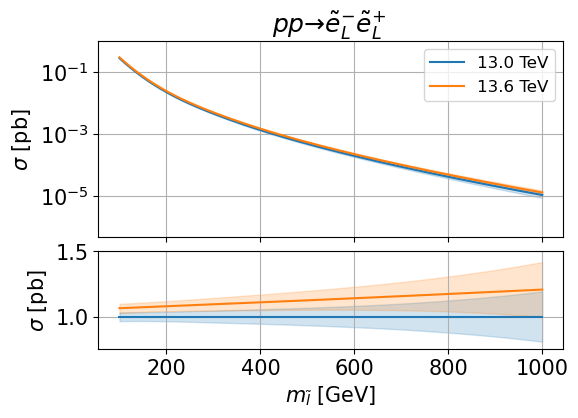

/home/apn/.local/lib/python3.9/site-packages/hepi/input.py:283: RuntimeWarning: Could not set new central scale to average of masses.
  warnings.warn("Could not set new central scale to average of masses.",


QUEUEING TASKS | Checking input:   0%|          | 0/470 [00:00<?, ?it/s]

PROCESSING TASKS | Checking input:   0%|          | 0/470 [00:00<?, ?it/s]

COLLECTING RESULTS | Checking input:   0%|          | 0/470 [00:00<?, ?it/s]

QUEUEING TASKS | Preparing:   0%|          | 0/470 [00:00<?, ?it/s]

PROCESSING TASKS | Preparing:   0%|          | 0/470 [00:00<?, ?it/s]

COLLECTING RESULTS | Preparing:   0%|          | 0/470 [00:00<?, ?it/s]

Skipped: 470 Not skipped: 0


QUEUEING TASKS | Running: 0it [00:00, ?it/s]

PROCESSING TASKS | Running: 0it [00:00, ?it/s]

COLLECTING RESULTS | Running: 0it [00:00, ?it/s]

QUEUEING TASKS | Parsing:   0%|          | 0/470 [00:00<?, ?it/s]

PROCESSING TASKS | Parsing:   0%|          | 0/470 [00:00<?, ?it/s]

COLLECTING RESULTS | Parsing:   0%|          | 0/470 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ LO:   0%|          | 0/10 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ LO:   0%|          | 0/10 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ LO:   0%|          | 0/10 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ NLO:   0%|          | 0/10 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ NLO:   0%|          | 0/10 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ NLO:   0%|          | 0/10 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/10 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/10 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/10 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ LO:   0%|          | 0/10 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ LO:   0%|          | 0/10 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ LO:   0%|          | 0/10 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ NLO:   0%|          | 0/10 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ NLO:   0%|          | 0/10 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ NLO:   0%|          | 0/10 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/10 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/10 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/10 [00:00<?, ?it/s]

/home/apn/.local/lib/python3.9/site-packages/hepi/input.py:283: RuntimeWarning: Could not set new central scale to average of masses.
  warnings.warn("Could not set new central scale to average of masses.",


QUEUEING TASKS | Checking input:   0%|          | 0/470 [00:00<?, ?it/s]

PROCESSING TASKS | Checking input:   0%|          | 0/470 [00:00<?, ?it/s]

COLLECTING RESULTS | Checking input:   0%|          | 0/470 [00:00<?, ?it/s]

QUEUEING TASKS | Preparing:   0%|          | 0/470 [00:00<?, ?it/s]

PROCESSING TASKS | Preparing:   0%|          | 0/470 [00:00<?, ?it/s]

COLLECTING RESULTS | Preparing:   0%|          | 0/470 [00:00<?, ?it/s]

Skipped: 470 Not skipped: 0


QUEUEING TASKS | Running: 0it [00:00, ?it/s]

PROCESSING TASKS | Running: 0it [00:00, ?it/s]

COLLECTING RESULTS | Running: 0it [00:00, ?it/s]

QUEUEING TASKS | Parsing:   0%|          | 0/470 [00:00<?, ?it/s]

PROCESSING TASKS | Parsing:   0%|          | 0/470 [00:00<?, ?it/s]

COLLECTING RESULTS | Parsing:   0%|          | 0/470 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ LO:   0%|          | 0/10 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ LO:   0%|          | 0/10 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ LO:   0%|          | 0/10 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ NLO:   0%|          | 0/10 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ NLO:   0%|          | 0/10 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ NLO:   0%|          | 0/10 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/10 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/10 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/10 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ LO:   0%|          | 0/10 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ LO:   0%|          | 0/10 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ LO:   0%|          | 0/10 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ NLO:   0%|          | 0/10 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ NLO:   0%|          | 0/10 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ NLO:   0%|          | 0/10 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/10 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/10 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/10 [00:00<?, ?it/s]

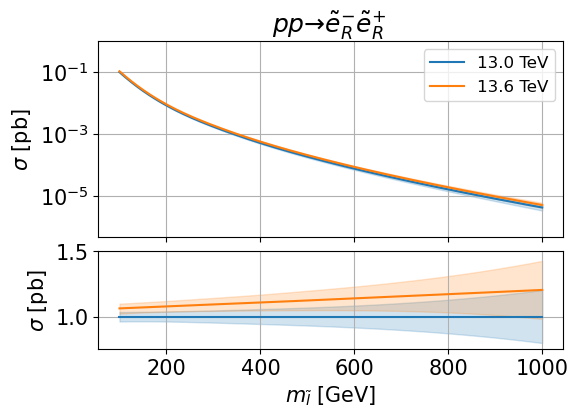

/home/apn/.local/lib/python3.9/site-packages/hepi/input.py:283: RuntimeWarning: Could not set new central scale to average of masses.
  warnings.warn("Could not set new central scale to average of masses.",


QUEUEING TASKS | Checking input:   0%|          | 0/470 [00:00<?, ?it/s]

PROCESSING TASKS | Checking input:   0%|          | 0/470 [00:00<?, ?it/s]

COLLECTING RESULTS | Checking input:   0%|          | 0/470 [00:00<?, ?it/s]

QUEUEING TASKS | Preparing:   0%|          | 0/470 [00:00<?, ?it/s]

PROCESSING TASKS | Preparing:   0%|          | 0/470 [00:00<?, ?it/s]

COLLECTING RESULTS | Preparing:   0%|          | 0/470 [00:00<?, ?it/s]

Skipped: 470 Not skipped: 0


QUEUEING TASKS | Running: 0it [00:00, ?it/s]

PROCESSING TASKS | Running: 0it [00:00, ?it/s]

COLLECTING RESULTS | Running: 0it [00:00, ?it/s]

QUEUEING TASKS | Parsing:   0%|          | 0/470 [00:00<?, ?it/s]

PROCESSING TASKS | Parsing:   0%|          | 0/470 [00:00<?, ?it/s]

COLLECTING RESULTS | Parsing:   0%|          | 0/470 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ LO:   0%|          | 0/10 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ LO:   0%|          | 0/10 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ LO:   0%|          | 0/10 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ NLO:   0%|          | 0/10 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ NLO:   0%|          | 0/10 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ NLO:   0%|          | 0/10 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/10 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/10 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/10 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ LO:   0%|          | 0/10 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ LO:   0%|          | 0/10 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ LO:   0%|          | 0/10 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ NLO:   0%|          | 0/10 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ NLO:   0%|          | 0/10 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ NLO:   0%|          | 0/10 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/10 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/10 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/10 [00:00<?, ?it/s]

/home/apn/.local/lib/python3.9/site-packages/hepi/input.py:283: RuntimeWarning: Could not set new central scale to average of masses.
  warnings.warn("Could not set new central scale to average of masses.",


QUEUEING TASKS | Checking input:   0%|          | 0/470 [00:00<?, ?it/s]

PROCESSING TASKS | Checking input:   0%|          | 0/470 [00:00<?, ?it/s]

COLLECTING RESULTS | Checking input:   0%|          | 0/470 [00:00<?, ?it/s]

QUEUEING TASKS | Preparing:   0%|          | 0/470 [00:00<?, ?it/s]

PROCESSING TASKS | Preparing:   0%|          | 0/470 [00:00<?, ?it/s]

COLLECTING RESULTS | Preparing:   0%|          | 0/470 [00:00<?, ?it/s]

Skipped: 470 Not skipped: 0


QUEUEING TASKS | Running: 0it [00:00, ?it/s]

PROCESSING TASKS | Running: 0it [00:00, ?it/s]

COLLECTING RESULTS | Running: 0it [00:00, ?it/s]

QUEUEING TASKS | Parsing:   0%|          | 0/470 [00:00<?, ?it/s]

PROCESSING TASKS | Parsing:   0%|          | 0/470 [00:00<?, ?it/s]

COLLECTING RESULTS | Parsing:   0%|          | 0/470 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ LO:   0%|          | 0/10 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ LO:   0%|          | 0/10 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ LO:   0%|          | 0/10 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ NLO:   0%|          | 0/10 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ NLO:   0%|          | 0/10 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ NLO:   0%|          | 0/10 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/10 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/10 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/10 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ LO:   0%|          | 0/10 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ LO:   0%|          | 0/10 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ LO:   0%|          | 0/10 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ NLO:   0%|          | 0/10 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ NLO:   0%|          | 0/10 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ NLO:   0%|          | 0/10 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/10 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/10 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/10 [00:00<?, ?it/s]

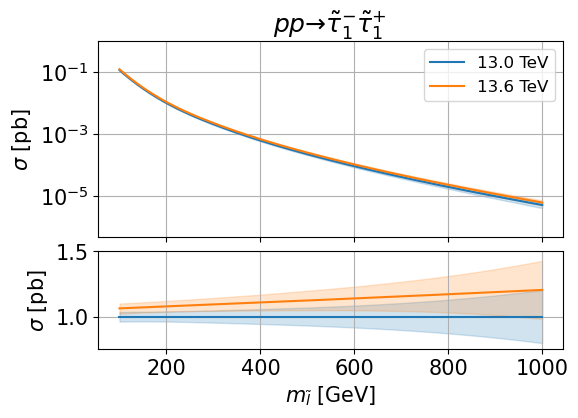

In [2]:
params = [
    "sleptons.slha",
]
pss = [
    (+1000011, -1000011),  # l_L^+ l_L^-
    (+2000011, -2000011),  # l_R^+ l_R^-
    (+1000015, -1000015),  # l_1^+ l_1^-
]
for pa, pb in pss:
    for energy in [13000, 13600]:
        name = str(energy) + "_sleptons_" + str(pa) + "_" + str(pb)
        hepi.set_output_dir("output_" + name +"/")
        rs.default_resummino_runner.set_output_dir(hepi.get_output_dir())
        for param in params:
            i = hepi.Input(
                hepi.Order.LO if test_lo else hepi.Order.aNNLO_PLUS_NNLL,
                energy,
                pa,
                pb,
                param,
                "PDF4LHC21_40",
                "PDF4LHC21_40",
                1.0,
                1.0,
                id="0.0.0",
                precision=0.001,
                max_iters=50,
            )
            li = [i]
            li = hepi.masses_scan(
                li,
                [
                    1000011,
                    2000011,
                    1000012,
                    1000013,
                    2000013,
                    1000014,
                    1000015,
                    2000015,
                    1000016,
                ],
                range(100, 1010, 100),
            )
            ms = "mass_1000011_2000011_1000012_1000013_2000013_1000014_1000015_2000015_1000016"
            if test_lo:
                rs_dl = rs.run(li, skip=False, run=True, parse=True)
                hepi.mass_plot(rs_dl,"LO",1000011,show=True,interpolator='exp')
            else:
                li = hepi.seven_point_scan(li)
                li = hepi.pdf_scan(li)
                # li = hepi.change_where(li, {"precision": 0.0001, "max_iters": 200}, pdfset_nlo=0)
                if generate:
                    rs_dl = rs.run(li, skip=False, run=False, parse=False)
                else:
                    if analyse:
                        rs_dl = rs.run(li, skip=True, run=True, parse=True,ignore_error=True)
                        rs_dl = hepi.pdf_errors(li,rs_dl)
                        rs_dl = hepi.scale_errors(li,rs_dl)
                        rs_dl = hepi.combine_errors(rs_dl)
                        hepi.write_json(rs_dl[rs_dl["aNNLO_PLUS_NNLL_COMBINED"].notnull()],hepi.Order.aNNLO_PLUS_NNLL,[ms],name + "_NNLL.json",error_asym=True)
                        hepi.write_latex_table_transposed_header(rs_dl,"aNNLO_PLUS_NNLL",param+str(energy)+".tex",ms)
                        hepi.write_latex_table_transposed(rs_dl,"aNNLO_PLUS_NNLL",param+str(energy)+".tex",yscale=1000.)
                    if plot:
                        rs_dl = hepi.load_json(open(name + "_NNLL.json"),1)
                        if energy == 13000:
                            fig, axs = plt.subplots(2, 1, figsize=(6,4), sharex=True, gridspec_kw={'height_ratios': [2, 1]})         # Remove horizontal space between axes         
                            fig.subplots_adjust(hspace=0.1)
                            hepi.title(li[0],axe=axs[0],cms_energy=False,pdf_info=False,scenario="")
                            frac = rs_dl["aNNLO_PLUS_NNLL_NOERR"][rs_dl["aNNLO_PLUS_NNLL_COMBINED"].notnull()]
                        hepi.combined_plot(rs_dl,ms,"aNNLO_PLUS_NNLL",axes=axs[0],tight=False,show=False,plot_data=False,logy=True,interpolate=True,interpolator='cubic',pre=lambda a :np.log(a.clip(min=1e-22)),post=np.exp,init=False,label="13.0 TeV" if energy == 13000 else "13.6 TeV" )
                        hepi.combined_plot(rs_dl,ms,"aNNLO_PLUS_NNLL",yscale=1./frac,axes=axs[1],tight=False,show=False,plot_data=False,logy=False,interpolate=True,interpolator='cubic',pre=lambda a :np.log(a.clip(min=1e-22)),post=np.exp,init=False,label="" )
                        axs[0].set_ylim(5e-7,1)
                        axs[1].set_ylim(0.75,1.5)
                        axs[0].set_xlabel(None)
                        axs[1].set_xlabel('$m_{\\tilde{l}}$ [GeV]')
                        if energy == 13600:
                            plt.savefig(name + ".pdf",bbox_inches ='tight',pad_inches=0)
                            plt.show()
                    

# aNNLO+NNLL wino


/home/apn/.local/lib/python3.9/site-packages/hepi/input.py:283: RuntimeWarning: Could not set new central scale to average of masses.
  warnings.warn("Could not set new central scale to average of masses.",


QUEUEING TASKS | Checking input:   0%|          | 0/940 [00:00<?, ?it/s]

PROCESSING TASKS | Checking input:   0%|          | 0/940 [00:00<?, ?it/s]

COLLECTING RESULTS | Checking input:   0%|          | 0/940 [00:00<?, ?it/s]

QUEUEING TASKS | Preparing:   0%|          | 0/940 [00:00<?, ?it/s]

PROCESSING TASKS | Preparing:   0%|          | 0/940 [00:00<?, ?it/s]

COLLECTING RESULTS | Preparing:   0%|          | 0/940 [00:00<?, ?it/s]

Skipped: 940 Not skipped: 0


QUEUEING TASKS | Parsing:   0%|          | 0/940 [00:00<?, ?it/s]

PROCESSING TASKS | Parsing:   0%|          | 0/940 [00:00<?, ?it/s]

COLLECTING RESULTS | Parsing:   0%|          | 0/940 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ LO:   0%|          | 0/20 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ LO:   0%|          | 0/20 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ LO:   0%|          | 0/20 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ NLO:   0%|          | 0/20 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ NLO:   0%|          | 0/20 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ NLO:   0%|          | 0/20 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/20 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/20 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/20 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ LO:   0%|          | 0/20 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ LO:   0%|          | 0/20 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ LO:   0%|          | 0/20 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ NLO:   0%|          | 0/20 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ NLO:   0%|          | 0/20 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ NLO:   0%|          | 0/20 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/20 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/20 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/20 [00:00<?, ?it/s]

/home/apn/.local/lib/python3.9/site-packages/hepi/input.py:283: RuntimeWarning: Could not set new central scale to average of masses.
  warnings.warn("Could not set new central scale to average of masses.",


QUEUEING TASKS | Checking input:   0%|          | 0/940 [00:00<?, ?it/s]

PROCESSING TASKS | Checking input:   0%|          | 0/940 [00:00<?, ?it/s]

COLLECTING RESULTS | Checking input:   0%|          | 0/940 [00:00<?, ?it/s]

QUEUEING TASKS | Preparing:   0%|          | 0/940 [00:00<?, ?it/s]

PROCESSING TASKS | Preparing:   0%|          | 0/940 [00:00<?, ?it/s]

COLLECTING RESULTS | Preparing:   0%|          | 0/940 [00:00<?, ?it/s]

Skipped: 940 Not skipped: 0


QUEUEING TASKS | Parsing:   0%|          | 0/940 [00:00<?, ?it/s]

PROCESSING TASKS | Parsing:   0%|          | 0/940 [00:00<?, ?it/s]

COLLECTING RESULTS | Parsing:   0%|          | 0/940 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ LO:   0%|          | 0/20 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ LO:   0%|          | 0/20 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ LO:   0%|          | 0/20 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ NLO:   0%|          | 0/20 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ NLO:   0%|          | 0/20 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ NLO:   0%|          | 0/20 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/20 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/20 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/20 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ LO:   0%|          | 0/20 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ LO:   0%|          | 0/20 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ LO:   0%|          | 0/20 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ NLO:   0%|          | 0/20 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ NLO:   0%|          | 0/20 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ NLO:   0%|          | 0/20 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/20 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/20 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/20 [00:00<?, ?it/s]

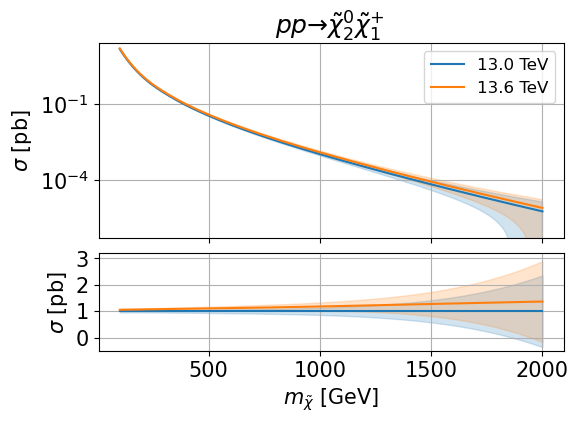

/home/apn/.local/lib/python3.9/site-packages/hepi/input.py:283: RuntimeWarning: Could not set new central scale to average of masses.
  warnings.warn("Could not set new central scale to average of masses.",


QUEUEING TASKS | Checking input:   0%|          | 0/940 [00:00<?, ?it/s]

PROCESSING TASKS | Checking input:   0%|          | 0/940 [00:00<?, ?it/s]

COLLECTING RESULTS | Checking input:   0%|          | 0/940 [00:00<?, ?it/s]

QUEUEING TASKS | Preparing:   0%|          | 0/940 [00:00<?, ?it/s]

PROCESSING TASKS | Preparing:   0%|          | 0/940 [00:00<?, ?it/s]

COLLECTING RESULTS | Preparing:   0%|          | 0/940 [00:00<?, ?it/s]

Skipped: 940 Not skipped: 0


QUEUEING TASKS | Parsing:   0%|          | 0/940 [00:00<?, ?it/s]

PROCESSING TASKS | Parsing:   0%|          | 0/940 [00:00<?, ?it/s]

COLLECTING RESULTS | Parsing:   0%|          | 0/940 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ LO:   0%|          | 0/20 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ LO:   0%|          | 0/20 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ LO:   0%|          | 0/20 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ NLO:   0%|          | 0/20 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ NLO:   0%|          | 0/20 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ NLO:   0%|          | 0/20 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/20 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/20 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/20 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ LO:   0%|          | 0/20 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ LO:   0%|          | 0/20 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ LO:   0%|          | 0/20 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ NLO:   0%|          | 0/20 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ NLO:   0%|          | 0/20 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ NLO:   0%|          | 0/20 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/20 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/20 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/20 [00:00<?, ?it/s]

/home/apn/.local/lib/python3.9/site-packages/hepi/input.py:283: RuntimeWarning: Could not set new central scale to average of masses.
  warnings.warn("Could not set new central scale to average of masses.",


QUEUEING TASKS | Checking input:   0%|          | 0/940 [00:00<?, ?it/s]

PROCESSING TASKS | Checking input:   0%|          | 0/940 [00:00<?, ?it/s]

COLLECTING RESULTS | Checking input:   0%|          | 0/940 [00:00<?, ?it/s]

QUEUEING TASKS | Preparing:   0%|          | 0/940 [00:00<?, ?it/s]

PROCESSING TASKS | Preparing:   0%|          | 0/940 [00:00<?, ?it/s]

COLLECTING RESULTS | Preparing:   0%|          | 0/940 [00:00<?, ?it/s]

Skipped: 940 Not skipped: 0


QUEUEING TASKS | Parsing:   0%|          | 0/940 [00:00<?, ?it/s]

PROCESSING TASKS | Parsing:   0%|          | 0/940 [00:00<?, ?it/s]

COLLECTING RESULTS | Parsing:   0%|          | 0/940 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ LO:   0%|          | 0/20 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ LO:   0%|          | 0/20 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ LO:   0%|          | 0/20 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ NLO:   0%|          | 0/20 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ NLO:   0%|          | 0/20 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ NLO:   0%|          | 0/20 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/20 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/20 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/20 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ LO:   0%|          | 0/20 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ LO:   0%|          | 0/20 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ LO:   0%|          | 0/20 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ NLO:   0%|          | 0/20 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ NLO:   0%|          | 0/20 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ NLO:   0%|          | 0/20 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/20 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/20 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/20 [00:00<?, ?it/s]

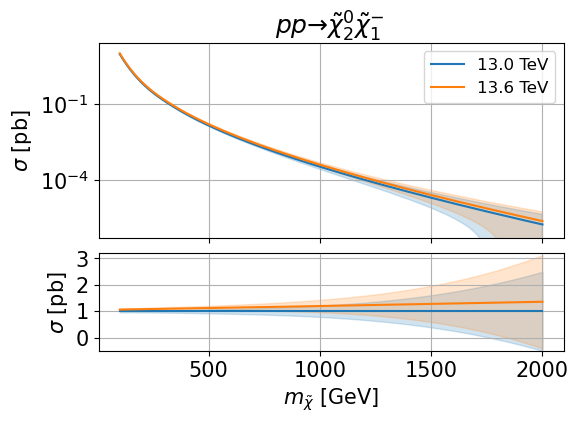

/home/apn/.local/lib/python3.9/site-packages/hepi/input.py:283: RuntimeWarning: Could not set new central scale to average of masses.
  warnings.warn("Could not set new central scale to average of masses.",


QUEUEING TASKS | Checking input:   0%|          | 0/940 [00:00<?, ?it/s]

PROCESSING TASKS | Checking input:   0%|          | 0/940 [00:00<?, ?it/s]

COLLECTING RESULTS | Checking input:   0%|          | 0/940 [00:00<?, ?it/s]

QUEUEING TASKS | Preparing:   0%|          | 0/940 [00:00<?, ?it/s]

PROCESSING TASKS | Preparing:   0%|          | 0/940 [00:00<?, ?it/s]

COLLECTING RESULTS | Preparing:   0%|          | 0/940 [00:00<?, ?it/s]

Skipped: 940 Not skipped: 0


QUEUEING TASKS | Parsing:   0%|          | 0/940 [00:00<?, ?it/s]

PROCESSING TASKS | Parsing:   0%|          | 0/940 [00:00<?, ?it/s]

COLLECTING RESULTS | Parsing:   0%|          | 0/940 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ LO:   0%|          | 0/20 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ LO:   0%|          | 0/20 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ LO:   0%|          | 0/20 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ NLO:   0%|          | 0/20 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ NLO:   0%|          | 0/20 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ NLO:   0%|          | 0/20 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/20 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/20 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/20 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ LO:   0%|          | 0/20 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ LO:   0%|          | 0/20 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ LO:   0%|          | 0/20 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ NLO:   0%|          | 0/20 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ NLO:   0%|          | 0/20 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ NLO:   0%|          | 0/20 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/20 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/20 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/20 [00:00<?, ?it/s]

/home/apn/.local/lib/python3.9/site-packages/hepi/input.py:283: RuntimeWarning: Could not set new central scale to average of masses.
  warnings.warn("Could not set new central scale to average of masses.",


QUEUEING TASKS | Checking input:   0%|          | 0/940 [00:00<?, ?it/s]

PROCESSING TASKS | Checking input:   0%|          | 0/940 [00:00<?, ?it/s]

COLLECTING RESULTS | Checking input:   0%|          | 0/940 [00:00<?, ?it/s]

QUEUEING TASKS | Preparing:   0%|          | 0/940 [00:00<?, ?it/s]

PROCESSING TASKS | Preparing:   0%|          | 0/940 [00:00<?, ?it/s]

COLLECTING RESULTS | Preparing:   0%|          | 0/940 [00:00<?, ?it/s]

Skipped: 940 Not skipped: 0


QUEUEING TASKS | Parsing:   0%|          | 0/940 [00:00<?, ?it/s]

PROCESSING TASKS | Parsing:   0%|          | 0/940 [00:00<?, ?it/s]

COLLECTING RESULTS | Parsing:   0%|          | 0/940 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ LO:   0%|          | 0/20 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ LO:   0%|          | 0/20 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ LO:   0%|          | 0/20 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ NLO:   0%|          | 0/20 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ NLO:   0%|          | 0/20 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ NLO:   0%|          | 0/20 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/20 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/20 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/20 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ LO:   0%|          | 0/20 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ LO:   0%|          | 0/20 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ LO:   0%|          | 0/20 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ NLO:   0%|          | 0/20 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ NLO:   0%|          | 0/20 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ NLO:   0%|          | 0/20 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/20 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/20 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/20 [00:00<?, ?it/s]

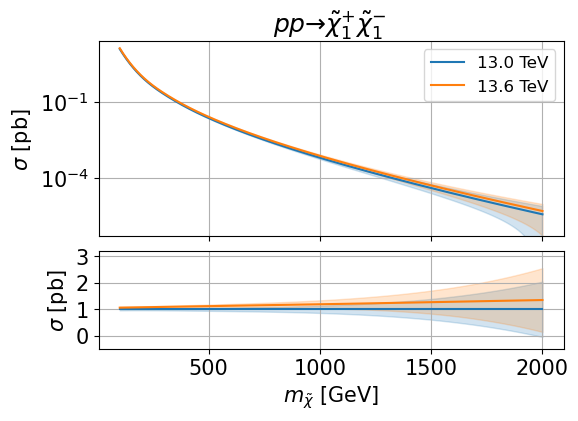

In [3]:
params = [
    "wino.slha",
]
pss = [
    ( 1000023, +1000024),  # N1C1p
    ( 1000023, -1000024),  # N1C1m
    (+1000024, -1000024),  # C1pC1m
]
for pa, pb in pss:
    for energy in [13000, 
                   13600
                  ]:
        name = str(energy) + "_wino_" + str(pa) + "_" + str(pb)
        hepi.set_output_dir(
               "output_" + name + "/"
        )
        rs.default_resummino_runner.set_output_dir(hepi.get_output_dir())
        for param in params:
            i = hepi.Input(
                hepi.Order.LO if test_lo else hepi.Order.aNNLO_PLUS_NNLL,
                    energy,
                    pa,
                    pb,
                    param,
                    "PDF4LHC21_40",
                    "PDF4LHC21_40",
                    1.0,
                    1.0,
                    id="0.0.0",
                    precision=0.001,
                    max_iters=50,
                )
            li = [i]
            li = hepi.masses_scan(
                    li,
                    [
                        1000022,
                        1000023,
                        1000024,
                    ],
                    range(100,2010,100),
                )
            ms = "mass_1000022_1000023_1000024"
            if test_lo:
                rs_dl = rs.run(li, skip=True, run=True, parse=True)
                hepi.mass_plot(rs_dl,"LO",1000022,show=True,interpolator='cubic',pre=np.log,post=np.exp)
            else:
                li = hepi.seven_point_scan(li)
                li = hepi.pdf_scan(li)
                    # li = hepi.change_where(li, {"precision": 0.0001, "max_iters": 200}, pdfset_nlo=0)
                if generate:
                    rs_dl = rs.run(li, skip=False, run=False, parse=False)
                else:
                    if analyse:
                        rs_dl = rs.run(li, skip=True, run=False, parse=True)
                        rs_dl = hepi.pdf_errors(li,rs_dl)
                        rs_dl = hepi.scale_errors(li,rs_dl)
                        rs_dl = hepi.combine_errors(rs_dl)
                        hepi.write_json(rs_dl[rs_dl["aNNLO_PLUS_NNLL_COMBINED"].notnull()],hepi.Order.aNNLO_PLUS_NNLL,[ms],name + "_NNLL.json",error_asym=True)
                        hepi.write_latex_table_transposed_header(rs_dl,"aNNLO_PLUS_NNLL",param+str(energy)+".tex",ms)
                        hepi.write_latex_table_transposed(rs_dl,"aNNLO_PLUS_NNLL",param+str(energy)+".tex",yscale=1000.)
                    if plot:
                        rs_dl = hepi.load_json(open(name + "_NNLL.json"),1)
                        if energy == 13000:
                            fig, axs = plt.subplots(2, 1, figsize=(6,4), sharex=True, gridspec_kw={'height_ratios': [2, 1]})         # Remove horizontal space between axes         
                            fig.subplots_adjust(hspace=0.1)
                            hepi.title(li[0],axe=axs[0],cms_energy=False,pdf_info=False,scenario="")
                            frac = rs_dl["aNNLO_PLUS_NNLL_NOERR"][rs_dl["aNNLO_PLUS_NNLL_COMBINED"].notnull()]
                        hepi.combined_plot(rs_dl,ms,"aNNLO_PLUS_NNLL",axes=axs[0],tight=False,show=False,plot_data=False,logy=True,interpolate=True,interpolator='cubic',pre=lambda a :np.log(a.clip(min=1e-22)),post=np.exp,init=False,label="13.0 TeV" if energy == 13000 else "13.6 TeV" )
                        hepi.combined_plot(rs_dl,ms,"aNNLO_PLUS_NNLL",yscale=1./frac,axes=axs[1],tight=False,show=False,plot_data=False,logy=False,interpolate=True,interpolator='cubic',pre=lambda a :np.log(a.clip(min=1e-22)),post=np.exp,init=False,label="" )
                        axs[0].set_ylim(5e-7,25)
                        axs[1].set_ylim(-0.5,3.2)
                        axs[0].set_xlabel(None)
                        axs[1].set_xlabel('$m_{\\tilde{\\chi}}$ [GeV]')
                        axs[1].set_yticks(np.arange(0,4,step=1))
                        if energy == 13600:
                            plt.savefig(name + ".pdf",bbox_inches ='tight',pad_inches=0)
                            plt.show()
                    

# aNNLO+NNLL hino degenerate


/home/apn/.local/lib/python3.9/site-packages/hepi/input.py:283: RuntimeWarning: Could not set new central scale to average of masses.
  warnings.warn("Could not set new central scale to average of masses.",


QUEUEING TASKS | Checking input:   0%|          | 0/705 [00:00<?, ?it/s]

PROCESSING TASKS | Checking input:   0%|          | 0/705 [00:00<?, ?it/s]

COLLECTING RESULTS | Checking input:   0%|          | 0/705 [00:00<?, ?it/s]

QUEUEING TASKS | Preparing:   0%|          | 0/705 [00:00<?, ?it/s]

PROCESSING TASKS | Preparing:   0%|          | 0/705 [00:00<?, ?it/s]

COLLECTING RESULTS | Preparing:   0%|          | 0/705 [00:00<?, ?it/s]

Skipped: 705 Not skipped: 0


QUEUEING TASKS | Parsing:   0%|          | 0/705 [00:00<?, ?it/s]

PROCESSING TASKS | Parsing:   0%|          | 0/705 [00:00<?, ?it/s]

COLLECTING RESULTS | Parsing:   0%|          | 0/705 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ LO:   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ LO:   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ LO:   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ NLO:   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ NLO:   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ NLO:   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ LO:   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ LO:   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ LO:   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ NLO:   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ NLO:   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ NLO:   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/15 [00:00<?, ?it/s]

/home/apn/.local/lib/python3.9/site-packages/hepi/input.py:283: RuntimeWarning: Could not set new central scale to average of masses.
  warnings.warn("Could not set new central scale to average of masses.",


QUEUEING TASKS | Checking input:   0%|          | 0/705 [00:00<?, ?it/s]

PROCESSING TASKS | Checking input:   0%|          | 0/705 [00:00<?, ?it/s]

COLLECTING RESULTS | Checking input:   0%|          | 0/705 [00:00<?, ?it/s]

QUEUEING TASKS | Preparing:   0%|          | 0/705 [00:00<?, ?it/s]

PROCESSING TASKS | Preparing:   0%|          | 0/705 [00:00<?, ?it/s]

COLLECTING RESULTS | Preparing:   0%|          | 0/705 [00:00<?, ?it/s]

Skipped: 705 Not skipped: 0


QUEUEING TASKS | Parsing:   0%|          | 0/705 [00:00<?, ?it/s]

PROCESSING TASKS | Parsing:   0%|          | 0/705 [00:00<?, ?it/s]

COLLECTING RESULTS | Parsing:   0%|          | 0/705 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ LO:   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ LO:   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ LO:   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ NLO:   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ NLO:   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ NLO:   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ LO:   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ LO:   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ LO:   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ NLO:   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ NLO:   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ NLO:   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/15 [00:00<?, ?it/s]

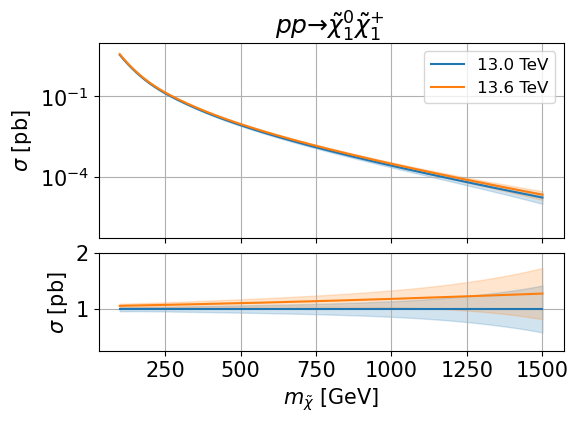

/home/apn/.local/lib/python3.9/site-packages/hepi/input.py:283: RuntimeWarning: Could not set new central scale to average of masses.
  warnings.warn("Could not set new central scale to average of masses.",


QUEUEING TASKS | Checking input:   0%|          | 0/705 [00:00<?, ?it/s]

PROCESSING TASKS | Checking input:   0%|          | 0/705 [00:00<?, ?it/s]

COLLECTING RESULTS | Checking input:   0%|          | 0/705 [00:00<?, ?it/s]

QUEUEING TASKS | Preparing:   0%|          | 0/705 [00:00<?, ?it/s]

PROCESSING TASKS | Preparing:   0%|          | 0/705 [00:00<?, ?it/s]

COLLECTING RESULTS | Preparing:   0%|          | 0/705 [00:00<?, ?it/s]

Skipped: 705 Not skipped: 0


QUEUEING TASKS | Parsing:   0%|          | 0/705 [00:00<?, ?it/s]

PROCESSING TASKS | Parsing:   0%|          | 0/705 [00:00<?, ?it/s]

COLLECTING RESULTS | Parsing:   0%|          | 0/705 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ LO:   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ LO:   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ LO:   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ NLO:   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ NLO:   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ NLO:   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ LO:   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ LO:   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ LO:   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ NLO:   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ NLO:   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ NLO:   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/15 [00:00<?, ?it/s]

/home/apn/.local/lib/python3.9/site-packages/hepi/input.py:283: RuntimeWarning: Could not set new central scale to average of masses.
  warnings.warn("Could not set new central scale to average of masses.",


QUEUEING TASKS | Checking input:   0%|          | 0/705 [00:00<?, ?it/s]

PROCESSING TASKS | Checking input:   0%|          | 0/705 [00:00<?, ?it/s]

COLLECTING RESULTS | Checking input:   0%|          | 0/705 [00:00<?, ?it/s]

QUEUEING TASKS | Preparing:   0%|          | 0/705 [00:00<?, ?it/s]

PROCESSING TASKS | Preparing:   0%|          | 0/705 [00:00<?, ?it/s]

COLLECTING RESULTS | Preparing:   0%|          | 0/705 [00:00<?, ?it/s]

Skipped: 705 Not skipped: 0


QUEUEING TASKS | Parsing:   0%|          | 0/705 [00:00<?, ?it/s]

PROCESSING TASKS | Parsing:   0%|          | 0/705 [00:00<?, ?it/s]

COLLECTING RESULTS | Parsing:   0%|          | 0/705 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ LO:   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ LO:   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ LO:   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ NLO:   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ NLO:   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ NLO:   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ LO:   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ LO:   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ LO:   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ NLO:   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ NLO:   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ NLO:   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/15 [00:00<?, ?it/s]

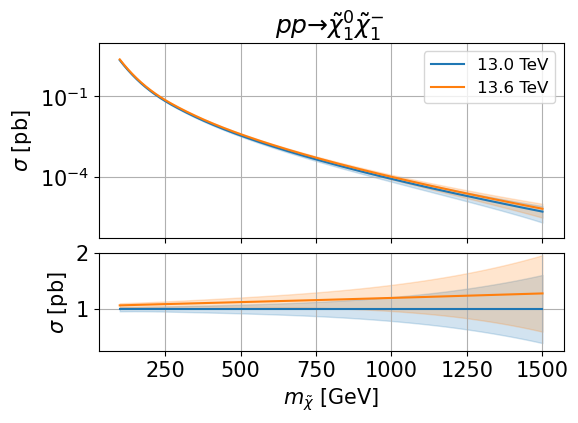

/home/apn/.local/lib/python3.9/site-packages/hepi/input.py:283: RuntimeWarning: Could not set new central scale to average of masses.
  warnings.warn("Could not set new central scale to average of masses.",


QUEUEING TASKS | Checking input:   0%|          | 0/705 [00:00<?, ?it/s]

PROCESSING TASKS | Checking input:   0%|          | 0/705 [00:00<?, ?it/s]

COLLECTING RESULTS | Checking input:   0%|          | 0/705 [00:00<?, ?it/s]

QUEUEING TASKS | Preparing:   0%|          | 0/705 [00:00<?, ?it/s]

PROCESSING TASKS | Preparing:   0%|          | 0/705 [00:00<?, ?it/s]

COLLECTING RESULTS | Preparing:   0%|          | 0/705 [00:00<?, ?it/s]

Skipped: 705 Not skipped: 0


QUEUEING TASKS | Parsing:   0%|          | 0/705 [00:00<?, ?it/s]

PROCESSING TASKS | Parsing:   0%|          | 0/705 [00:00<?, ?it/s]

COLLECTING RESULTS | Parsing:   0%|          | 0/705 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ LO:   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ LO:   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ LO:   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ NLO:   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ NLO:   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ NLO:   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ LO:   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ LO:   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ LO:   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ NLO:   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ NLO:   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ NLO:   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/15 [00:00<?, ?it/s]

/home/apn/.local/lib/python3.9/site-packages/hepi/input.py:283: RuntimeWarning: Could not set new central scale to average of masses.
  warnings.warn("Could not set new central scale to average of masses.",


QUEUEING TASKS | Checking input:   0%|          | 0/705 [00:00<?, ?it/s]

PROCESSING TASKS | Checking input:   0%|          | 0/705 [00:00<?, ?it/s]

COLLECTING RESULTS | Checking input:   0%|          | 0/705 [00:00<?, ?it/s]

QUEUEING TASKS | Preparing:   0%|          | 0/705 [00:00<?, ?it/s]

PROCESSING TASKS | Preparing:   0%|          | 0/705 [00:00<?, ?it/s]

COLLECTING RESULTS | Preparing:   0%|          | 0/705 [00:00<?, ?it/s]

Skipped: 705 Not skipped: 0


QUEUEING TASKS | Parsing:   0%|          | 0/705 [00:00<?, ?it/s]

PROCESSING TASKS | Parsing:   0%|          | 0/705 [00:00<?, ?it/s]

COLLECTING RESULTS | Parsing:   0%|          | 0/705 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ LO:   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ LO:   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ LO:   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ NLO:   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ NLO:   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ NLO:   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ LO:   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ LO:   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ LO:   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ NLO:   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ NLO:   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ NLO:   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/15 [00:00<?, ?it/s]

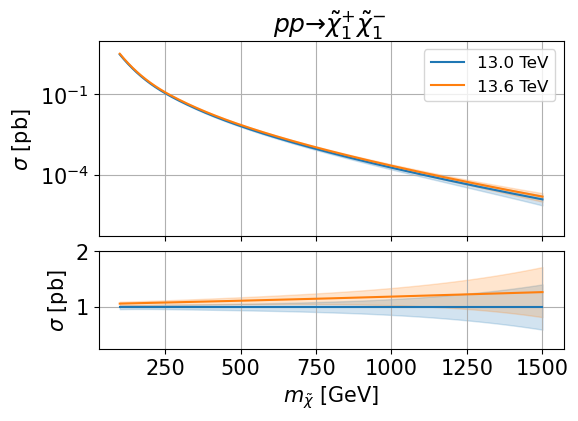

/home/apn/.local/lib/python3.9/site-packages/hepi/input.py:283: RuntimeWarning: Could not set new central scale to average of masses.
  warnings.warn("Could not set new central scale to average of masses.",


QUEUEING TASKS | Checking input:   0%|          | 0/705 [00:00<?, ?it/s]

PROCESSING TASKS | Checking input:   0%|          | 0/705 [00:00<?, ?it/s]

COLLECTING RESULTS | Checking input:   0%|          | 0/705 [00:00<?, ?it/s]

QUEUEING TASKS | Preparing:   0%|          | 0/705 [00:00<?, ?it/s]

PROCESSING TASKS | Preparing:   0%|          | 0/705 [00:00<?, ?it/s]

COLLECTING RESULTS | Preparing:   0%|          | 0/705 [00:00<?, ?it/s]

Skipped: 705 Not skipped: 0


QUEUEING TASKS | Parsing:   0%|          | 0/705 [00:00<?, ?it/s]

PROCESSING TASKS | Parsing:   0%|          | 0/705 [00:00<?, ?it/s]

COLLECTING RESULTS | Parsing:   0%|          | 0/705 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ LO:   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ LO:   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ LO:   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ NLO:   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ NLO:   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ NLO:   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ LO:   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ LO:   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ LO:   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ NLO:   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ NLO:   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ NLO:   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/15 [00:00<?, ?it/s]

/home/apn/.local/lib/python3.9/site-packages/hepi/input.py:283: RuntimeWarning: Could not set new central scale to average of masses.
  warnings.warn("Could not set new central scale to average of masses.",


QUEUEING TASKS | Checking input:   0%|          | 0/705 [00:00<?, ?it/s]

PROCESSING TASKS | Checking input:   0%|          | 0/705 [00:00<?, ?it/s]

COLLECTING RESULTS | Checking input:   0%|          | 0/705 [00:00<?, ?it/s]

QUEUEING TASKS | Preparing:   0%|          | 0/705 [00:00<?, ?it/s]

PROCESSING TASKS | Preparing:   0%|          | 0/705 [00:00<?, ?it/s]

COLLECTING RESULTS | Preparing:   0%|          | 0/705 [00:00<?, ?it/s]

Skipped: 705 Not skipped: 0


QUEUEING TASKS | Parsing:   0%|          | 0/705 [00:00<?, ?it/s]

PROCESSING TASKS | Parsing:   0%|          | 0/705 [00:00<?, ?it/s]

COLLECTING RESULTS | Parsing:   0%|          | 0/705 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ LO:   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ LO:   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ LO:   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ NLO:   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ NLO:   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ NLO:   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ LO:   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ LO:   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ LO:   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ NLO:   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ NLO:   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ NLO:   0%|          | 0/15 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/15 [00:00<?, ?it/s]

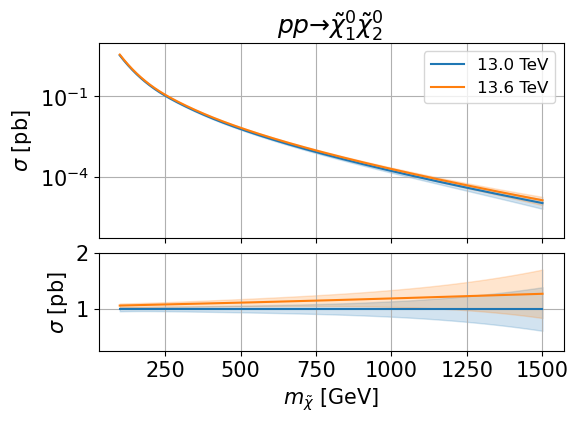

In [4]:
params = [
    "hino.slha",
]
pss = [
    (1000022, +1000024),  # N2C1p
    (1000022, -1000024),  # N2C1m
    (+1000024, -1000024),  # C1pC2m
    (1000022, 1000023),  # N2N1
]
for pa, pb in pss:
    for energy in [13000, 13600]:
        # save to different folders to have some substructure
        name = str(energy) + "_hino_deg_" + str(pa) + "_" + str(pb)
        hepi.set_output_dir(
            "output_" + name + "/"
        )
        rs.default_resummino_runner.set_output_dir(hepi.get_output_dir())
        for param in params:
            i = hepi.Input(
                hepi.Order.LO if test_lo else hepi.Order.aNNLO_PLUS_NNLL,
                energy,
                pa,
                pb,
                param,
                "PDF4LHC21_40",
                "PDF4LHC21_40",
                1.0,
                1.0,
                id="0.0.0",
                precision=0.001,
                max_iters=50,
            )
            li = [i]
            li = hepi.masses_scan(
                li,
                [
                    1000022,
                    1000023,
                    1000024,
                ],
                range(100, 1510, 100),
                negate=[1000022],
            )
            ms = "mass_1000022_1000023_1000024"
            if test_lo:
                rs_dl = rs.run(li, skip=False, run=True, parse=True)
                hepi.mass_plot(rs_dl,"LO",1000023,show=True,interpolator='exp')
            else:
                li = hepi.seven_point_scan(li)
                li = hepi.pdf_scan(li)
                # li = hepi.change_where(li, {"precision": 0.0001, "max_iters": 200}, pdfset_nlo=0)
                if generate:
                    rs_dl = rs.run(li, skip=False, run=False, parse=False)
                else:
                    if analyse:
                        rs_dl = rs.run(li, skip=True, run=False, parse=True,ignore_error=True)
                        rs_dl = hepi.pdf_errors(li,rs_dl)
                        rs_dl = hepi.scale_errors(li,rs_dl)
                        rs_dl = hepi.combine_errors(rs_dl)
                        hepi.write_json(rs_dl[rs_dl["aNNLO_PLUS_NNLL_COMBINED"].notnull()],hepi.Order.aNNLO_PLUS_NNLL,[ms],name + "_NNLL.json",error_asym=True)
                        hepi.write_latex_table_transposed_header(rs_dl,"aNNLO_PLUS_NNLL",param+str(energy)+".tex",ms)
                        hepi.write_latex_table_transposed(rs_dl,"aNNLO_PLUS_NNLL",param+str(energy)+".tex",yscale=1000.)
                    if plot:    
                        rs_dl = hepi.load_json(open(name + "_NNLL.json"),1)
                        if energy == 13000:
                            fig, axs = plt.subplots(2, 1, figsize=(6,4), sharex=True, gridspec_kw={'height_ratios': [2, 1]})         # Remove horizontal space between axes         
                            fig.subplots_adjust(hspace=0.1)
                            hepi.title(li[0],axe=axs[0],cms_energy=False,pdf_info=False,scenario="")
                            frac = rs_dl["aNNLO_PLUS_NNLL_NOERR"][rs_dl["aNNLO_PLUS_NNLL_COMBINED"].notnull()]
                        hepi.combined_plot(rs_dl,ms,"aNNLO_PLUS_NNLL",axes=axs[0],tight=False,show=False,plot_data=False,logy=True,interpolate=True,interpolator='cubic',pre=lambda a :np.log(a.clip(min=1e-22)),post=np.exp,init=False,label="13.0 TeV" if energy == 13000 else "13.6 TeV" )
                        hepi.combined_plot(rs_dl,ms,"aNNLO_PLUS_NNLL",yscale=1./frac,axes=axs[1],tight=False,show=False,plot_data=False,logy=False,interpolate=True,interpolator='cubic',pre=lambda a :np.log(a.clip(min=1e-22)),post=np.exp,init=False,label="" )
                        axs[0].set_ylim(5e-7,10)
                        axs[1].set_ylim(0.25,2)
                        axs[0].set_xlabel(None)
                        axs[1].set_xlabel('$m_{\\tilde{\\chi}}$ [GeV]')
                        if energy == 13600:
                            plt.savefig(name + ".pdf",bbox_inches ='tight',pad_inches=0)
                            plt.show()
                    

# aNNLO+NNLL hino non-degenerate

/home/apn/.local/lib/python3.9/site-packages/hepi/util.py:169: UserWarning: PDF set 'CTEQ6.6 and MSTW2008nlo90cl' not installed?
  warnings.warn("PDF set '" + name + "' not installed?")
/home/apn/.local/lib/python3.9/site-packages/hepi/input.py:283: RuntimeWarning: Could not set new central scale to average of masses.
  warnings.warn("Could not set new central scale to average of masses.",


QUEUEING TASKS | Checking input:   0%|          | 0/3431 [00:00<?, ?it/s]

PROCESSING TASKS | Checking input:   0%|          | 0/3431 [00:00<?, ?it/s]

COLLECTING RESULTS | Checking input:   0%|          | 0/3431 [00:00<?, ?it/s]

QUEUEING TASKS | Preparing:   0%|          | 0/3431 [00:00<?, ?it/s]

PROCESSING TASKS | Preparing:   0%|          | 0/3431 [00:00<?, ?it/s]

COLLECTING RESULTS | Preparing:   0%|          | 0/3431 [00:00<?, ?it/s]

Skipped: 3431 Not skipped: 0


QUEUEING TASKS | Parsing:   0%|          | 0/3431 [00:00<?, ?it/s]

PROCESSING TASKS | Parsing:   0%|          | 0/3431 [00:00<?, ?it/s]

COLLECTING RESULTS | Parsing:   0%|          | 0/3431 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ LO:   0%|          | 0/73 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ LO:   0%|          | 0/73 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ LO:   0%|          | 0/73 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ NLO:   0%|          | 0/73 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ NLO:   0%|          | 0/73 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ NLO:   0%|          | 0/73 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/73 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/73 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/73 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ LO:   0%|          | 0/73 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ LO:   0%|          | 0/73 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ LO:   0%|          | 0/73 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ NLO:   0%|          | 0/73 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ NLO:   0%|          | 0/73 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ NLO:   0%|          | 0/73 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/73 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/73 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/73 [00:00<?, ?it/s]

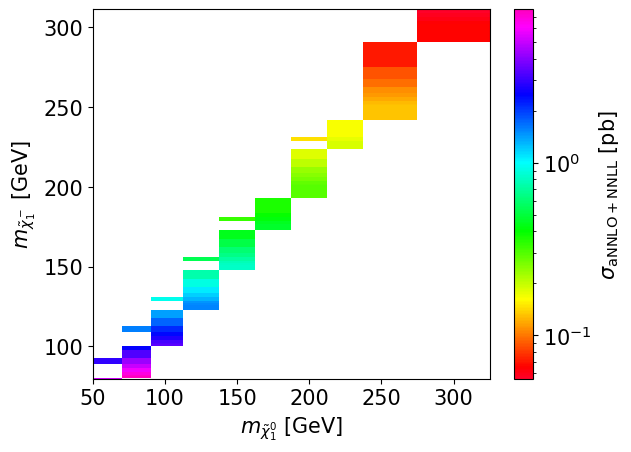

/usr/lib/python3.9/site-packages/numpy/lib/function_base.py:2411: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)


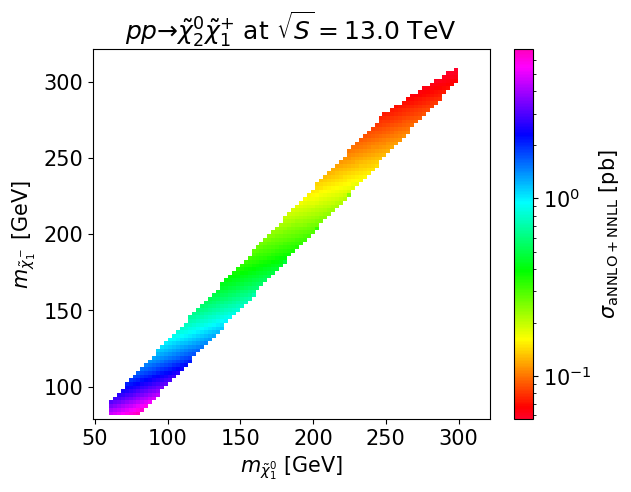

/home/apn/.local/lib/python3.9/site-packages/hepi/input.py:283: RuntimeWarning: Could not set new central scale to average of masses.
  warnings.warn("Could not set new central scale to average of masses.",


QUEUEING TASKS | Checking input:   0%|          | 0/3431 [00:00<?, ?it/s]

PROCESSING TASKS | Checking input:   0%|          | 0/3431 [00:00<?, ?it/s]

COLLECTING RESULTS | Checking input:   0%|          | 0/3431 [00:00<?, ?it/s]

QUEUEING TASKS | Preparing:   0%|          | 0/3431 [00:00<?, ?it/s]

PROCESSING TASKS | Preparing:   0%|          | 0/3431 [00:00<?, ?it/s]

COLLECTING RESULTS | Preparing:   0%|          | 0/3431 [00:00<?, ?it/s]

Skipped: 3431 Not skipped: 0


QUEUEING TASKS | Parsing:   0%|          | 0/3431 [00:00<?, ?it/s]

PROCESSING TASKS | Parsing:   0%|          | 0/3431 [00:00<?, ?it/s]

COLLECTING RESULTS | Parsing:   0%|          | 0/3431 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ LO:   0%|          | 0/73 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ LO:   0%|          | 0/73 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ LO:   0%|          | 0/73 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ NLO:   0%|          | 0/73 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ NLO:   0%|          | 0/73 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ NLO:   0%|          | 0/73 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/73 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/73 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/73 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ LO:   0%|          | 0/73 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ LO:   0%|          | 0/73 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ LO:   0%|          | 0/73 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ NLO:   0%|          | 0/73 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ NLO:   0%|          | 0/73 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ NLO:   0%|          | 0/73 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/73 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/73 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/73 [00:00<?, ?it/s]

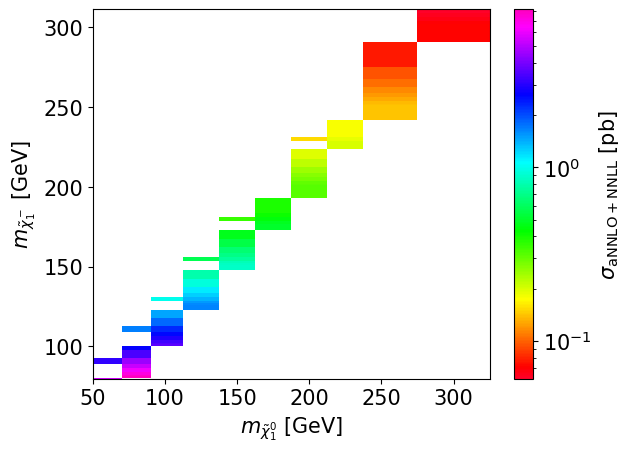

/usr/lib/python3.9/site-packages/numpy/lib/function_base.py:2411: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)


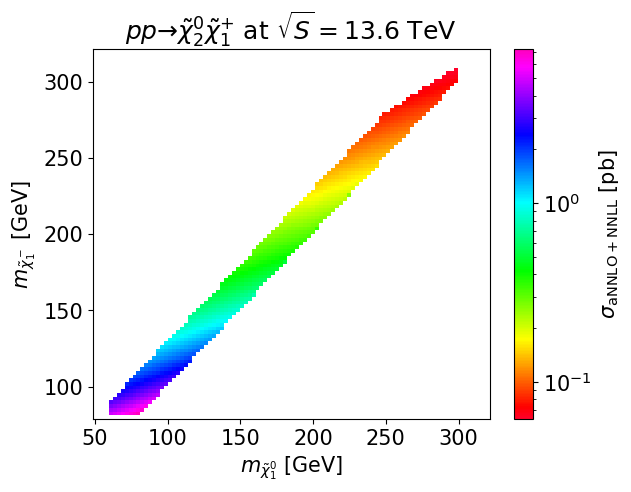

/home/apn/.local/lib/python3.9/site-packages/hepi/input.py:283: RuntimeWarning: Could not set new central scale to average of masses.
  warnings.warn("Could not set new central scale to average of masses.",


QUEUEING TASKS | Checking input:   0%|          | 0/3431 [00:00<?, ?it/s]

PROCESSING TASKS | Checking input:   0%|          | 0/3431 [00:00<?, ?it/s]

COLLECTING RESULTS | Checking input:   0%|          | 0/3431 [00:00<?, ?it/s]

QUEUEING TASKS | Preparing:   0%|          | 0/3431 [00:00<?, ?it/s]

PROCESSING TASKS | Preparing:   0%|          | 0/3431 [00:00<?, ?it/s]

COLLECTING RESULTS | Preparing:   0%|          | 0/3431 [00:00<?, ?it/s]

Skipped: 3431 Not skipped: 0


QUEUEING TASKS | Parsing:   0%|          | 0/3431 [00:00<?, ?it/s]

PROCESSING TASKS | Parsing:   0%|          | 0/3431 [00:00<?, ?it/s]

COLLECTING RESULTS | Parsing:   0%|          | 0/3431 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ LO:   0%|          | 0/73 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ LO:   0%|          | 0/73 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ LO:   0%|          | 0/73 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ NLO:   0%|          | 0/73 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ NLO:   0%|          | 0/73 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ NLO:   0%|          | 0/73 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/73 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/73 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/73 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ LO:   0%|          | 0/73 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ LO:   0%|          | 0/73 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ LO:   0%|          | 0/73 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ NLO:   0%|          | 0/73 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ NLO:   0%|          | 0/73 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ NLO:   0%|          | 0/73 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/73 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/73 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/73 [00:00<?, ?it/s]

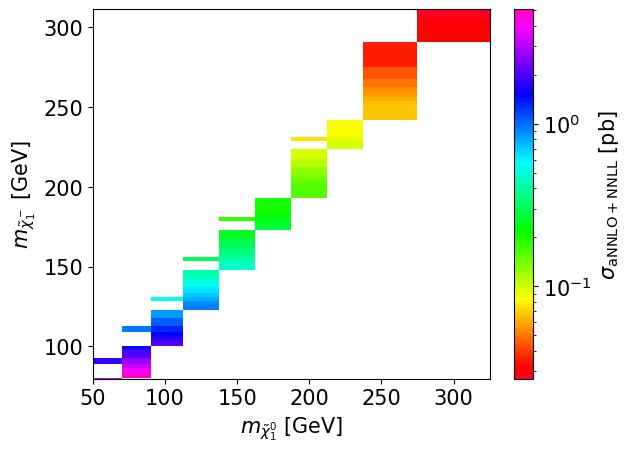

/usr/lib/python3.9/site-packages/numpy/lib/function_base.py:2411: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)


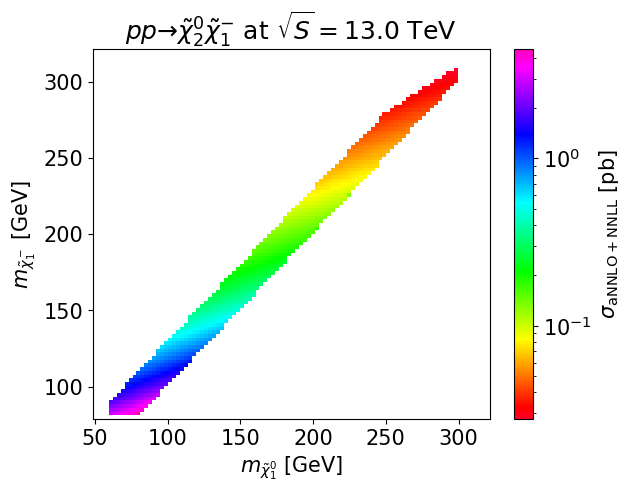

/home/apn/.local/lib/python3.9/site-packages/hepi/input.py:283: RuntimeWarning: Could not set new central scale to average of masses.
  warnings.warn("Could not set new central scale to average of masses.",


QUEUEING TASKS | Checking input:   0%|          | 0/3431 [00:00<?, ?it/s]

PROCESSING TASKS | Checking input:   0%|          | 0/3431 [00:00<?, ?it/s]

COLLECTING RESULTS | Checking input:   0%|          | 0/3431 [00:00<?, ?it/s]

QUEUEING TASKS | Preparing:   0%|          | 0/3431 [00:00<?, ?it/s]

PROCESSING TASKS | Preparing:   0%|          | 0/3431 [00:00<?, ?it/s]

COLLECTING RESULTS | Preparing:   0%|          | 0/3431 [00:00<?, ?it/s]

Skipped: 3431 Not skipped: 0


QUEUEING TASKS | Parsing:   0%|          | 0/3431 [00:00<?, ?it/s]

PROCESSING TASKS | Parsing:   0%|          | 0/3431 [00:00<?, ?it/s]

COLLECTING RESULTS | Parsing:   0%|          | 0/3431 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ LO:   0%|          | 0/73 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ LO:   0%|          | 0/73 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ LO:   0%|          | 0/73 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ NLO:   0%|          | 0/73 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ NLO:   0%|          | 0/73 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ NLO:   0%|          | 0/73 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/73 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/73 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/73 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ LO:   0%|          | 0/73 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ LO:   0%|          | 0/73 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ LO:   0%|          | 0/73 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ NLO:   0%|          | 0/73 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ NLO:   0%|          | 0/73 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ NLO:   0%|          | 0/73 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/73 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/73 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/73 [00:00<?, ?it/s]

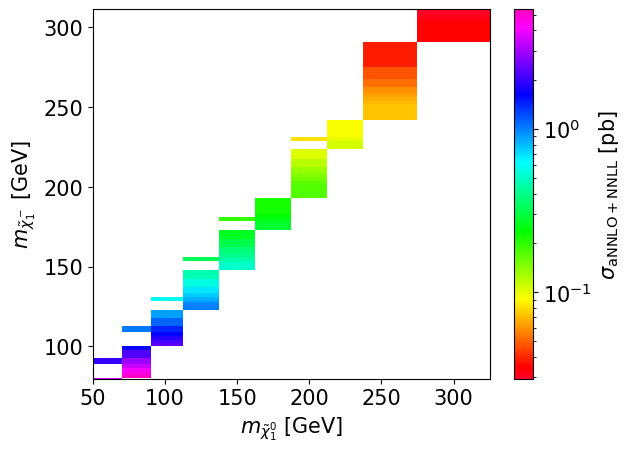

/usr/lib/python3.9/site-packages/numpy/lib/function_base.py:2411: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)


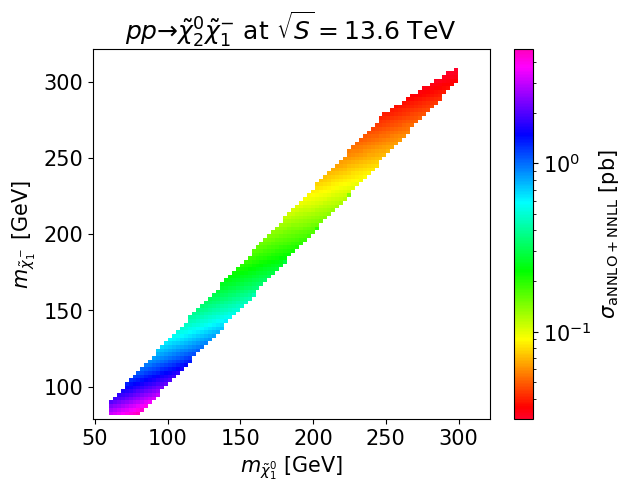

/home/apn/.local/lib/python3.9/site-packages/hepi/input.py:283: RuntimeWarning: Could not set new central scale to average of masses.
  warnings.warn("Could not set new central scale to average of masses.",


QUEUEING TASKS | Checking input:   0%|          | 0/3431 [00:00<?, ?it/s]

PROCESSING TASKS | Checking input:   0%|          | 0/3431 [00:00<?, ?it/s]

COLLECTING RESULTS | Checking input:   0%|          | 0/3431 [00:00<?, ?it/s]

QUEUEING TASKS | Preparing:   0%|          | 0/3431 [00:00<?, ?it/s]

PROCESSING TASKS | Preparing:   0%|          | 0/3431 [00:00<?, ?it/s]

COLLECTING RESULTS | Preparing:   0%|          | 0/3431 [00:00<?, ?it/s]

Skipped: 3431 Not skipped: 0


QUEUEING TASKS | Parsing:   0%|          | 0/3431 [00:00<?, ?it/s]

PROCESSING TASKS | Parsing:   0%|          | 0/3431 [00:00<?, ?it/s]

COLLECTING RESULTS | Parsing:   0%|          | 0/3431 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ LO:   0%|          | 0/73 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ LO:   0%|          | 0/73 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ LO:   0%|          | 0/73 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ NLO:   0%|          | 0/73 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ NLO:   0%|          | 0/73 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ NLO:   0%|          | 0/73 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/73 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/73 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/73 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ LO:   0%|          | 0/73 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ LO:   0%|          | 0/73 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ LO:   0%|          | 0/73 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ NLO:   0%|          | 0/73 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ NLO:   0%|          | 0/73 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ NLO:   0%|          | 0/73 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/73 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/73 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/73 [00:00<?, ?it/s]

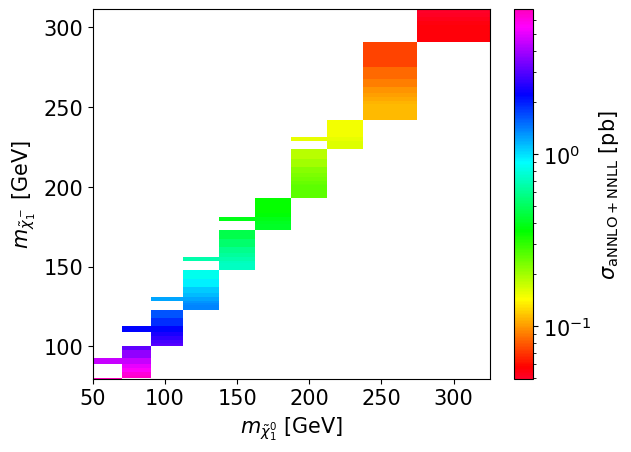

/usr/lib/python3.9/site-packages/numpy/lib/function_base.py:2411: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)


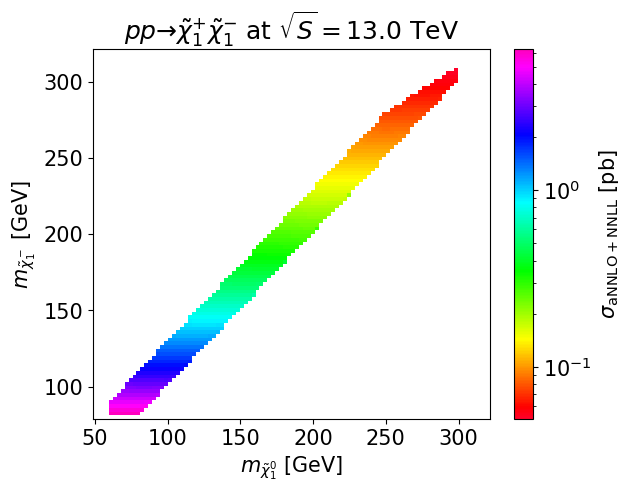

/home/apn/.local/lib/python3.9/site-packages/hepi/input.py:283: RuntimeWarning: Could not set new central scale to average of masses.
  warnings.warn("Could not set new central scale to average of masses.",


QUEUEING TASKS | Checking input:   0%|          | 0/3431 [00:00<?, ?it/s]

PROCESSING TASKS | Checking input:   0%|          | 0/3431 [00:00<?, ?it/s]

COLLECTING RESULTS | Checking input:   0%|          | 0/3431 [00:00<?, ?it/s]

QUEUEING TASKS | Preparing:   0%|          | 0/3431 [00:00<?, ?it/s]

PROCESSING TASKS | Preparing:   0%|          | 0/3431 [00:00<?, ?it/s]

COLLECTING RESULTS | Preparing:   0%|          | 0/3431 [00:00<?, ?it/s]

Skipped: 3431 Not skipped: 0


QUEUEING TASKS | Parsing:   0%|          | 0/3431 [00:00<?, ?it/s]

PROCESSING TASKS | Parsing:   0%|          | 0/3431 [00:00<?, ?it/s]

COLLECTING RESULTS | Parsing:   0%|          | 0/3431 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ LO:   0%|          | 0/73 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ LO:   0%|          | 0/73 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ LO:   0%|          | 0/73 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ NLO:   0%|          | 0/73 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ NLO:   0%|          | 0/73 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ NLO:   0%|          | 0/73 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/73 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/73 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/73 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ LO:   0%|          | 0/73 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ LO:   0%|          | 0/73 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ LO:   0%|          | 0/73 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ NLO:   0%|          | 0/73 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ NLO:   0%|          | 0/73 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ NLO:   0%|          | 0/73 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/73 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/73 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/73 [00:00<?, ?it/s]

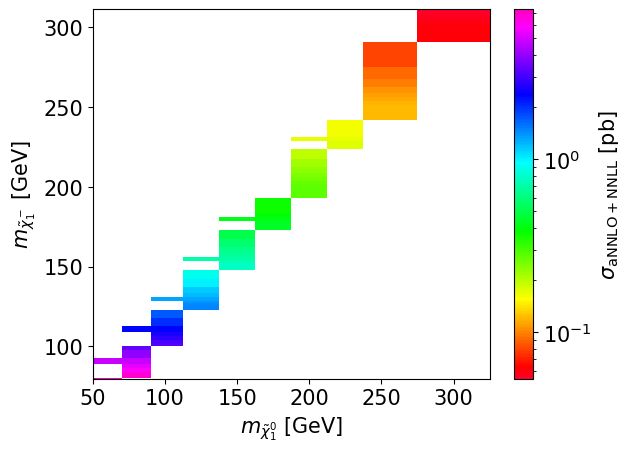

/usr/lib/python3.9/site-packages/numpy/lib/function_base.py:2411: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)


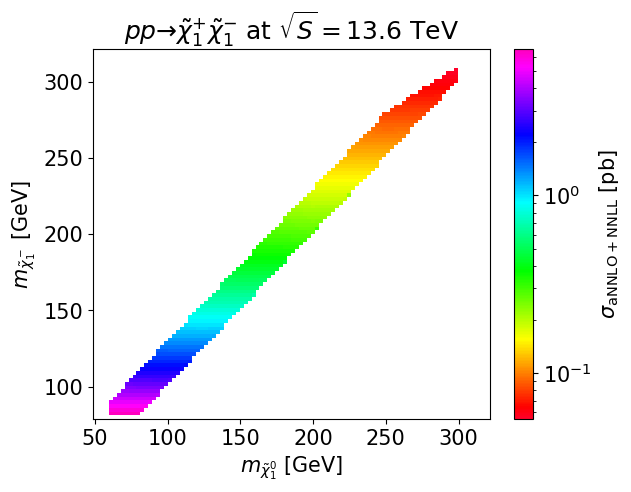

/home/apn/.local/lib/python3.9/site-packages/hepi/input.py:283: RuntimeWarning: Could not set new central scale to average of masses.
  warnings.warn("Could not set new central scale to average of masses.",


QUEUEING TASKS | Checking input:   0%|          | 0/3431 [00:00<?, ?it/s]

PROCESSING TASKS | Checking input:   0%|          | 0/3431 [00:00<?, ?it/s]

COLLECTING RESULTS | Checking input:   0%|          | 0/3431 [00:00<?, ?it/s]

QUEUEING TASKS | Preparing:   0%|          | 0/3431 [00:00<?, ?it/s]

PROCESSING TASKS | Preparing:   0%|          | 0/3431 [00:00<?, ?it/s]

COLLECTING RESULTS | Preparing:   0%|          | 0/3431 [00:00<?, ?it/s]

Skipped: 3431 Not skipped: 0


QUEUEING TASKS | Parsing:   0%|          | 0/3431 [00:00<?, ?it/s]

PROCESSING TASKS | Parsing:   0%|          | 0/3431 [00:00<?, ?it/s]

COLLECTING RESULTS | Parsing:   0%|          | 0/3431 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ LO:   0%|          | 0/73 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ LO:   0%|          | 0/73 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ LO:   0%|          | 0/73 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ NLO:   0%|          | 0/73 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ NLO:   0%|          | 0/73 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ NLO:   0%|          | 0/73 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/73 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/73 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/73 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ LO:   0%|          | 0/73 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ LO:   0%|          | 0/73 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ LO:   0%|          | 0/73 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ NLO:   0%|          | 0/73 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ NLO:   0%|          | 0/73 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ NLO:   0%|          | 0/73 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/73 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/73 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/73 [00:00<?, ?it/s]

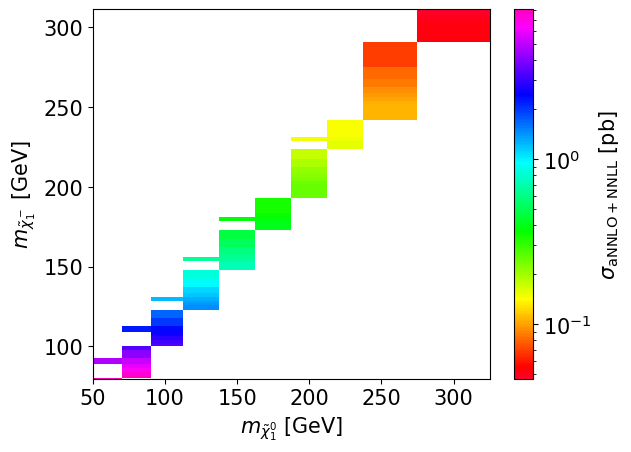

/usr/lib/python3.9/site-packages/numpy/lib/function_base.py:2411: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)


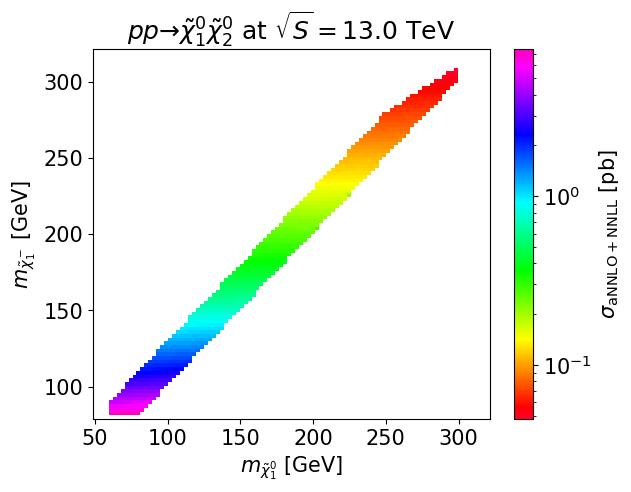

/home/apn/.local/lib/python3.9/site-packages/hepi/input.py:283: RuntimeWarning: Could not set new central scale to average of masses.
  warnings.warn("Could not set new central scale to average of masses.",


QUEUEING TASKS | Checking input:   0%|          | 0/3431 [00:00<?, ?it/s]

PROCESSING TASKS | Checking input:   0%|          | 0/3431 [00:00<?, ?it/s]

COLLECTING RESULTS | Checking input:   0%|          | 0/3431 [00:00<?, ?it/s]

QUEUEING TASKS | Preparing:   0%|          | 0/3431 [00:00<?, ?it/s]

PROCESSING TASKS | Preparing:   0%|          | 0/3431 [00:00<?, ?it/s]

COLLECTING RESULTS | Preparing:   0%|          | 0/3431 [00:00<?, ?it/s]

Skipped: 3431 Not skipped: 0


QUEUEING TASKS | Parsing:   0%|          | 0/3431 [00:00<?, ?it/s]

PROCESSING TASKS | Parsing:   0%|          | 0/3431 [00:00<?, ?it/s]

COLLECTING RESULTS | Parsing:   0%|          | 0/3431 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ LO:   0%|          | 0/73 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ LO:   0%|          | 0/73 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ LO:   0%|          | 0/73 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ NLO:   0%|          | 0/73 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ NLO:   0%|          | 0/73 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ NLO:   0%|          | 0/73 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/73 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/73 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/73 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ LO:   0%|          | 0/73 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ LO:   0%|          | 0/73 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ LO:   0%|          | 0/73 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ NLO:   0%|          | 0/73 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ NLO:   0%|          | 0/73 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ NLO:   0%|          | 0/73 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/73 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/73 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/73 [00:00<?, ?it/s]

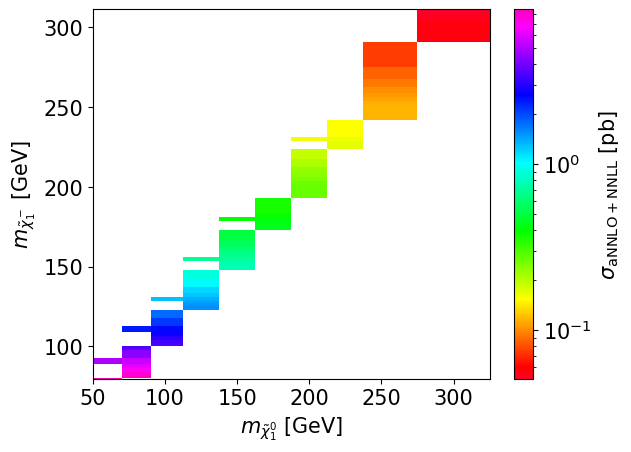

/usr/lib/python3.9/site-packages/numpy/lib/function_base.py:2411: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)


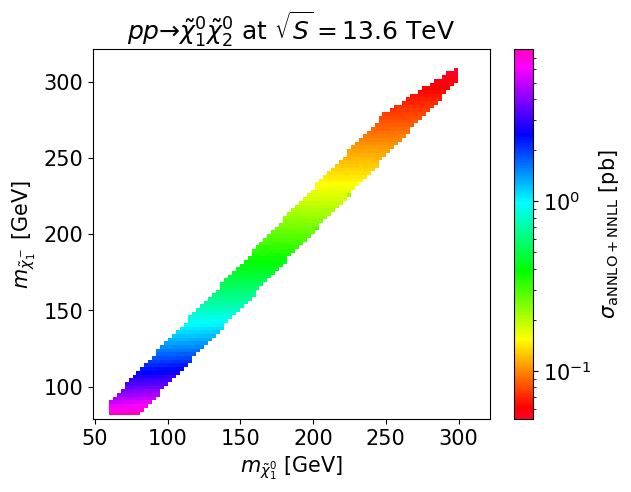

In [5]:
params = [
    "higgsino_slha_C1C1.slha",
]
pss = [
    ( 1000023, +1000024),  # N2C1p
    ( 1000023, -1000024),  # N2C1m
    (+1000024, -1000024),  # C1pC1m
    ( 1000022,  1000023),  # N2N1
]
import urllib

dl = hepi.load(
    urllib.request.urlopen(
        "https://raw.githubusercontent.com/APN-Pucky/xsec/master/json/pp13_hinosplit_N2N1_NLO%2BNLL.json"
    ),
    dimensions=2,
)
N1 = dl["N1"]
N2 = dl["N2"]
NX = dl["N1"] / 2 + dl["N2"] / 2
for pa, pb in pss:
    for energy in [13000, 13600]:
        # save to different folders to have some substructure
        name= str(energy) + "_hino_nondeg_" + str(pa) + "_" + str(pb)
        hepi.set_output_dir(
            "output_" + name + "/"
        )
        rs.default_resummino_runner.set_output_dir(hepi.get_output_dir())
        for param in params:
            i = hepi.Input(
                hepi.Order.LO if test_lo else hepi.Order.aNNLO_PLUS_NNLL,
                energy,
                pa,
                pb,
                param,
                "PDF4LHC21_40",
                "PDF4LHC21_40",
                1.0,
                1.0,
                id="0.0.0",
                precision=0.001,
                max_iters=50,
            )
            li = [i]
            li = hepi.slha_scan_rel(
                li,
                lambda r: [
                    ["MASS", 1000022, N1[r]],
                    ["MASS", 1000023, -N2[r]],
                    ["MASS", 1000024, NX[r]],
                ],
                range(len(N1)),
            )
            if test_lo:
                rs_dl = rs.run(li, skip=True, run=True, parse=True)
                hepi.mapplot(rs_dl,"MASS_1000022","MASS_1000024","LO",xaxis="$m_{\\tilde{\\chi}_1^0}$ [GeV]",yaxis="$m_{\\tilde{\\chi}_1^-}$ [GeV]" , zaxis="$\\sigma_{\\mathrm{NLO+NLL}}$ [pb]")
            else:    
                li = hepi.seven_point_scan(li)
                li = hepi.pdf_scan(li)
                # li = hepi.change_where(li, {"precision": 0.0001, "max_iters": 200}, pdfset_nlo=0)
                if generate:
                    rs_dl = rs.run(li, skip=True, run=False, parse=False)
                else:
                    if analyse:
                        rs_dl = rs.run(li, skip=True, run=False, parse=True)


                        rs_dl = hepi.pdf_errors(li,rs_dl)
                        rs_dl = hepi.scale_errors(li,rs_dl)
                        rs_dl = hepi.combine_errors(rs_dl)

                        hepi.write_json(rs_dl[rs_dl["aNNLO_PLUS_NNLL_COMBINED"].notnull()],hepi.Order.aNNLO_PLUS_NNLL,["MASS_1000022","MASS_1000024"],name + "_NNLL.json",error_asym=True)


                        hepi.write_latex_table_transposed_header(rs_dl,"aNNLO_PLUS_NNLL",param+str(energy)+".tex","MASS_1000022")
                        hepi.write_latex_table_transposed_header(rs_dl,"aNNLO_PLUS_NNLL",param+str(energy)+".tex","MASS_1000023")
                        hepi.write_latex_table_transposed_header(rs_dl,"aNNLO_PLUS_NNLL",param+str(energy)+".tex","MASS_1000024")
                        hepi.write_latex_table_transposed(rs_dl,"aNNLO_PLUS_NNLL",param+str(energy)+".tex",yscale=1000.)

                    if plot:
                        rs_dl = hepi.load_json(open(name + "_NNLL.json"),2)
                        mask = rs_dl["aNNLO_PLUS_NNLL_COMBINED"].notnull()
                        #"""
                        hepi.mapplot(rs_dl[mask],"MASS_1000022","MASS_1000024","aNNLO_PLUS_NNLL_COMBINED",xaxis="$m_{\\tilde{\\chi}_1^0}$ [GeV]",yaxis="$m_{\\tilde{\\chi}_1^-}$ [GeV]" , zaxis="$\\sigma_{\\mathrm{aNNLO+NNLL}}$ [pb]",cmap='gist_rainbow')

                        plt.show()
                        hepi.title(li[0],pdf_info=False,scenario="")

                        xx,yy = data.flatmesh(np.linspace(50,320,100),np.linspace(80,320,100))
                        dll = hepi.interpolate_2d(rs_dl[mask],"MASS_1000022","MASS_1000024","aNNLO_PLUS_NNLL_COMBINED",xx,yy,interpolator="linearnd",pre=np.log,post=np.exp)             
                        hepi.mapplot(dll,"MASS_1000022","MASS_1000024","aNNLO_PLUS_NNLL_COMBINED",xaxis="$m_{\\tilde{\\chi}_1^0}$ [GeV]",yaxis="$m_{\\tilde{\\chi}_1^-}$ [GeV]" , zaxis="$\\sigma_{\\mathrm{aNNLO+NNLL}}$ [pb]",fill_missing=False,cmap='gist_rainbow')

                        hepi.title(li[0],pdf_info=False,scenario="")
                        plt.savefig(name + ".pdf",bbox_inches ='tight',pad_inches=0)
                        plt.show()
                        #"""

## Squark mass dependence in wino-charginos

/home/apn/.local/lib/python3.9/site-packages/hepi/input.py:283: RuntimeWarning: Could not set new central scale to average of masses.
  warnings.warn("Could not set new central scale to average of masses.",


QUEUEING TASKS | Checking input:   0%|          | 0/18095 [00:00<?, ?it/s]

PROCESSING TASKS | Checking input:   0%|          | 0/18095 [00:00<?, ?it/s]

COLLECTING RESULTS | Checking input:   0%|          | 0/18095 [00:00<?, ?it/s]

QUEUEING TASKS | Preparing:   0%|          | 0/18095 [00:00<?, ?it/s]

PROCESSING TASKS | Preparing:   0%|          | 0/18095 [00:00<?, ?it/s]

COLLECTING RESULTS | Preparing:   0%|          | 0/18095 [00:00<?, ?it/s]

Skipped: 18095 Not skipped: 0


QUEUEING TASKS | Parsing:   0%|          | 0/18095 [00:00<?, ?it/s]

PROCESSING TASKS | Parsing:   0%|          | 0/18095 [00:00<?, ?it/s]

COLLECTING RESULTS | Parsing:   0%|          | 0/18095 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ LO:   0%|          | 0/385 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ LO:   0%|          | 0/385 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ LO:   0%|          | 0/385 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ NLO:   0%|          | 0/385 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ NLO:   0%|          | 0/385 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ NLO:   0%|          | 0/385 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/385 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/385 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/385 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ LO:   0%|          | 0/385 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ LO:   0%|          | 0/385 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ LO:   0%|          | 0/385 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ NLO:   0%|          | 0/385 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ NLO:   0%|          | 0/385 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ NLO:   0%|          | 0/385 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/385 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/385 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/385 [00:00<?, ?it/s]

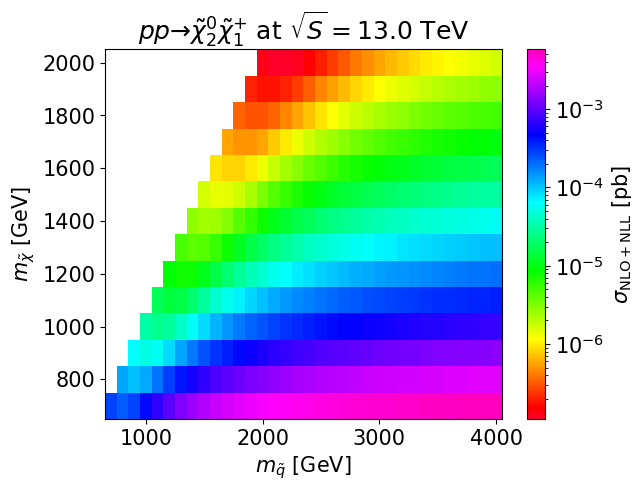

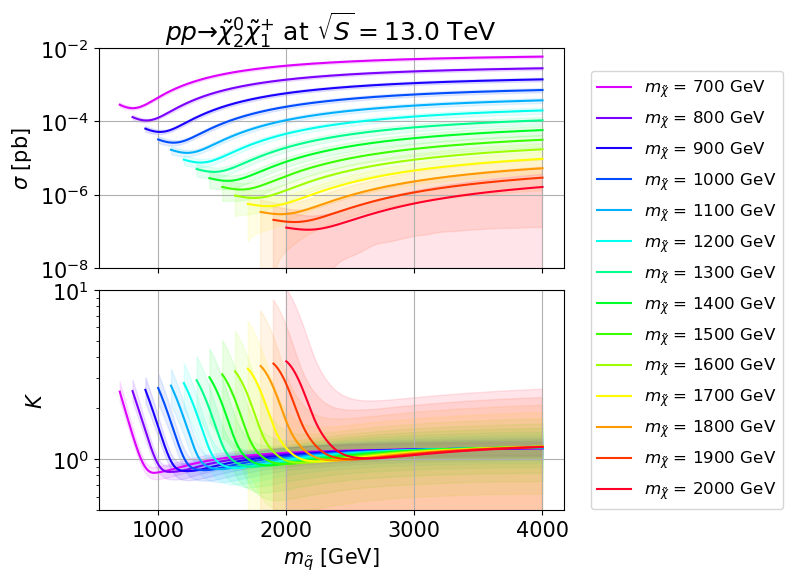

/home/apn/.local/lib/python3.9/site-packages/hepi/input.py:283: RuntimeWarning: Could not set new central scale to average of masses.
  warnings.warn("Could not set new central scale to average of masses.",


QUEUEING TASKS | Checking input:   0%|          | 0/18095 [00:00<?, ?it/s]

PROCESSING TASKS | Checking input:   0%|          | 0/18095 [00:00<?, ?it/s]

COLLECTING RESULTS | Checking input:   0%|          | 0/18095 [00:00<?, ?it/s]

QUEUEING TASKS | Preparing:   0%|          | 0/18095 [00:00<?, ?it/s]

PROCESSING TASKS | Preparing:   0%|          | 0/18095 [00:00<?, ?it/s]

COLLECTING RESULTS | Preparing:   0%|          | 0/18095 [00:00<?, ?it/s]

Skipped: 18095 Not skipped: 0


QUEUEING TASKS | Parsing:   0%|          | 0/18095 [00:00<?, ?it/s]

PROCESSING TASKS | Parsing:   0%|          | 0/18095 [00:00<?, ?it/s]

COLLECTING RESULTS | Parsing:   0%|          | 0/18095 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ LO:   0%|          | 0/385 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ LO:   0%|          | 0/385 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ LO:   0%|          | 0/385 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ NLO:   0%|          | 0/385 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ NLO:   0%|          | 0/385 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ NLO:   0%|          | 0/385 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/385 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/385 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/385 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ LO:   0%|          | 0/385 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ LO:   0%|          | 0/385 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ LO:   0%|          | 0/385 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ NLO:   0%|          | 0/385 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ NLO:   0%|          | 0/385 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ NLO:   0%|          | 0/385 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/385 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/385 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/385 [00:00<?, ?it/s]

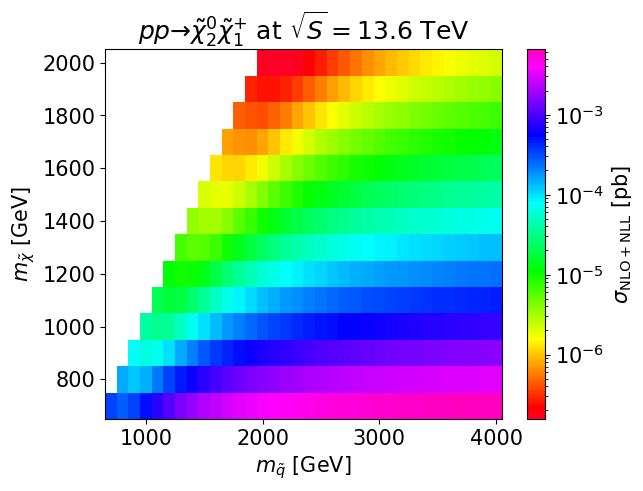

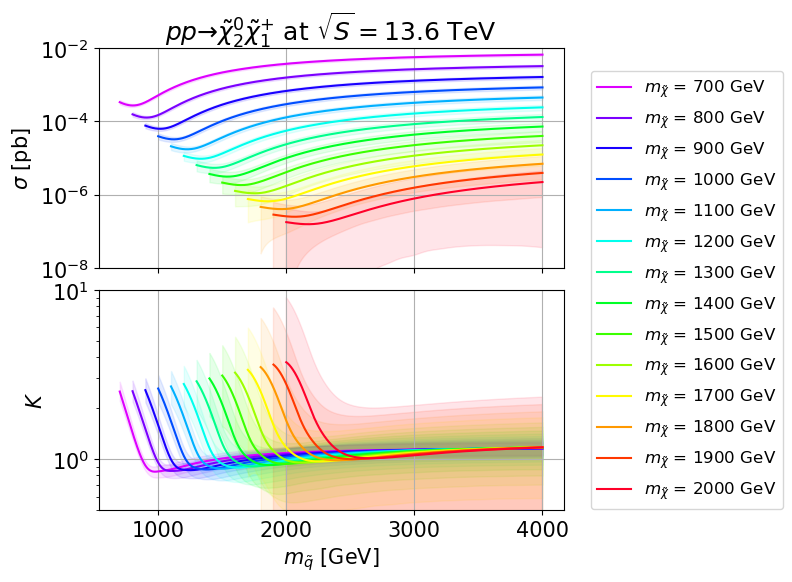

/home/apn/.local/lib/python3.9/site-packages/hepi/input.py:283: RuntimeWarning: Could not set new central scale to average of masses.
  warnings.warn("Could not set new central scale to average of masses.",


QUEUEING TASKS | Checking input:   0%|          | 0/18095 [00:00<?, ?it/s]

PROCESSING TASKS | Checking input:   0%|          | 0/18095 [00:00<?, ?it/s]

COLLECTING RESULTS | Checking input:   0%|          | 0/18095 [00:00<?, ?it/s]

QUEUEING TASKS | Preparing:   0%|          | 0/18095 [00:00<?, ?it/s]

PROCESSING TASKS | Preparing:   0%|          | 0/18095 [00:00<?, ?it/s]

COLLECTING RESULTS | Preparing:   0%|          | 0/18095 [00:00<?, ?it/s]

Skipped: 18095 Not skipped: 0


QUEUEING TASKS | Parsing:   0%|          | 0/18095 [00:00<?, ?it/s]

PROCESSING TASKS | Parsing:   0%|          | 0/18095 [00:00<?, ?it/s]

COLLECTING RESULTS | Parsing:   0%|          | 0/18095 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ LO:   0%|          | 0/385 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ LO:   0%|          | 0/385 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ LO:   0%|          | 0/385 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ NLO:   0%|          | 0/385 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ NLO:   0%|          | 0/385 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ NLO:   0%|          | 0/385 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/385 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/385 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/385 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ LO:   0%|          | 0/385 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ LO:   0%|          | 0/385 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ LO:   0%|          | 0/385 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ NLO:   0%|          | 0/385 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ NLO:   0%|          | 0/385 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ NLO:   0%|          | 0/385 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/385 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/385 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/385 [00:00<?, ?it/s]

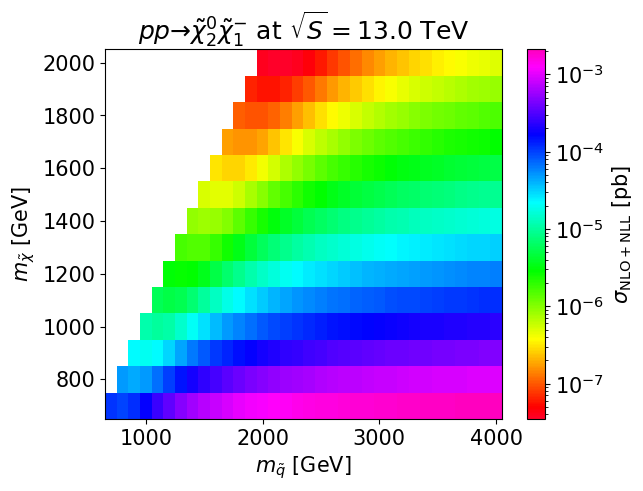

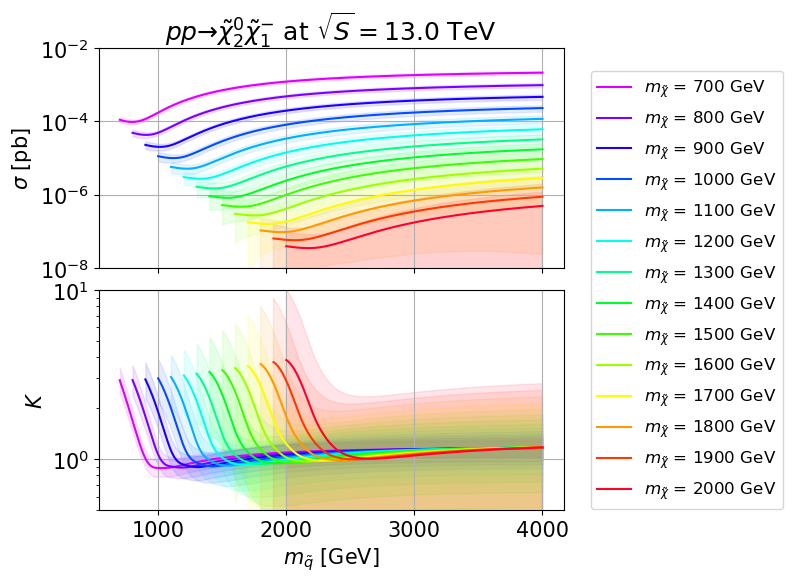

/home/apn/.local/lib/python3.9/site-packages/hepi/input.py:283: RuntimeWarning: Could not set new central scale to average of masses.
  warnings.warn("Could not set new central scale to average of masses.",


QUEUEING TASKS | Checking input:   0%|          | 0/18095 [00:00<?, ?it/s]

PROCESSING TASKS | Checking input:   0%|          | 0/18095 [00:00<?, ?it/s]

COLLECTING RESULTS | Checking input:   0%|          | 0/18095 [00:00<?, ?it/s]

QUEUEING TASKS | Preparing:   0%|          | 0/18095 [00:00<?, ?it/s]

PROCESSING TASKS | Preparing:   0%|          | 0/18095 [00:00<?, ?it/s]

COLLECTING RESULTS | Preparing:   0%|          | 0/18095 [00:00<?, ?it/s]

Skipped: 18095 Not skipped: 0


QUEUEING TASKS | Parsing:   0%|          | 0/18095 [00:00<?, ?it/s]

PROCESSING TASKS | Parsing:   0%|          | 0/18095 [00:00<?, ?it/s]

COLLECTING RESULTS | Parsing:   0%|          | 0/18095 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ LO:   0%|          | 0/385 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ LO:   0%|          | 0/385 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ LO:   0%|          | 0/385 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ NLO:   0%|          | 0/385 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ NLO:   0%|          | 0/385 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ NLO:   0%|          | 0/385 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/385 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/385 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/385 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ LO:   0%|          | 0/385 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ LO:   0%|          | 0/385 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ LO:   0%|          | 0/385 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ NLO:   0%|          | 0/385 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ NLO:   0%|          | 0/385 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ NLO:   0%|          | 0/385 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/385 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/385 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/385 [00:00<?, ?it/s]

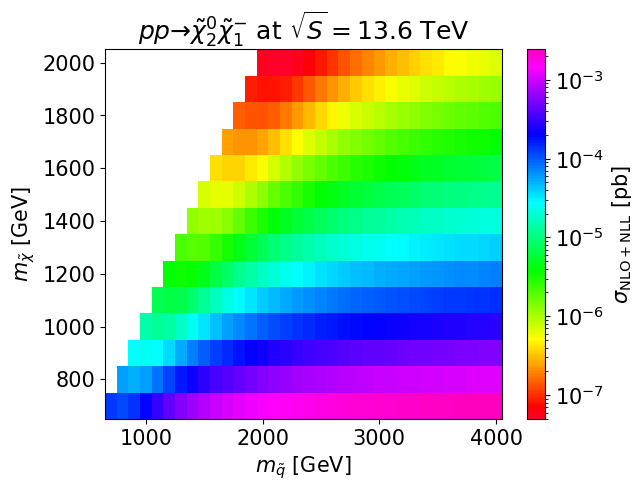

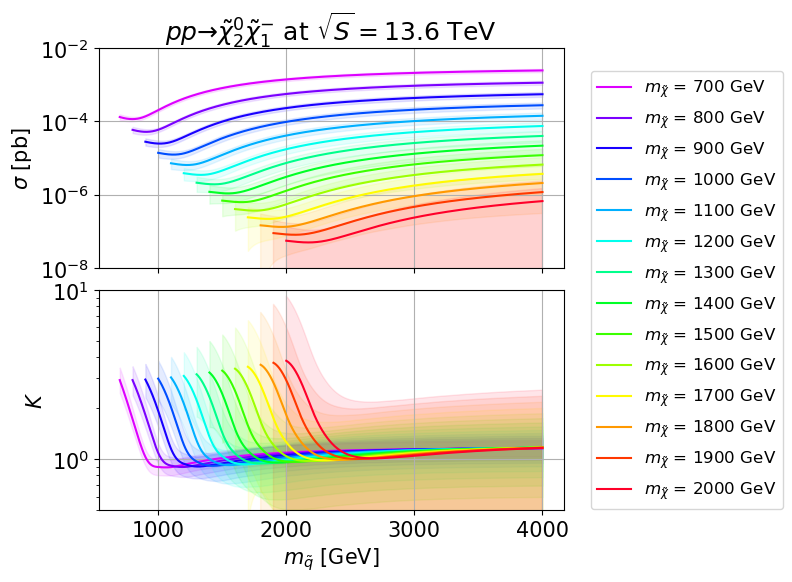

/home/apn/.local/lib/python3.9/site-packages/hepi/input.py:283: RuntimeWarning: Could not set new central scale to average of masses.
  warnings.warn("Could not set new central scale to average of masses.",


QUEUEING TASKS | Checking input:   0%|          | 0/18095 [00:00<?, ?it/s]

PROCESSING TASKS | Checking input:   0%|          | 0/18095 [00:00<?, ?it/s]

COLLECTING RESULTS | Checking input:   0%|          | 0/18095 [00:00<?, ?it/s]

QUEUEING TASKS | Preparing:   0%|          | 0/18095 [00:00<?, ?it/s]

PROCESSING TASKS | Preparing:   0%|          | 0/18095 [00:00<?, ?it/s]

COLLECTING RESULTS | Preparing:   0%|          | 0/18095 [00:00<?, ?it/s]

Skipped: 18095 Not skipped: 0


QUEUEING TASKS | Parsing:   0%|          | 0/18095 [00:00<?, ?it/s]

PROCESSING TASKS | Parsing:   0%|          | 0/18095 [00:00<?, ?it/s]

COLLECTING RESULTS | Parsing:   0%|          | 0/18095 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ LO:   0%|          | 0/385 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ LO:   0%|          | 0/385 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ LO:   0%|          | 0/385 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ NLO:   0%|          | 0/385 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ NLO:   0%|          | 0/385 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ NLO:   0%|          | 0/385 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/385 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/385 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/385 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ LO:   0%|          | 0/385 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ LO:   0%|          | 0/385 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ LO:   0%|          | 0/385 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ NLO:   0%|          | 0/385 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ NLO:   0%|          | 0/385 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ NLO:   0%|          | 0/385 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/385 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/385 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/385 [00:00<?, ?it/s]

/home/apn/.local/lib/python3.9/site-packages/hepi/results.py:286: RuntimeWarning: too bad numerical precision vs scale @ num:aNNLO_PLUS_NNLL 0.07665741620088581% vs scale:0.29986370825677056% to -0.027506980040417697%
  warnings.warn(
/home/apn/.local/lib/python3.9/site-packages/hepi/results.py:286: RuntimeWarning: too bad numerical precision vs scale @ num:aNNLO_PLUS_NNLL 0.06992909910990806% vs scale:0.321484789478548% to -0.007460741522581249%
  warnings.warn(
/home/apn/.local/lib/python3.9/site-packages/hepi/results.py:286: RuntimeWarning: too bad numerical precision vs scale @ num:aNNLO_PLUS_NNLL 0.06735863048102599% vs scale:0.2276409986890738% to -0.02938495874186143%
  warnings.warn(


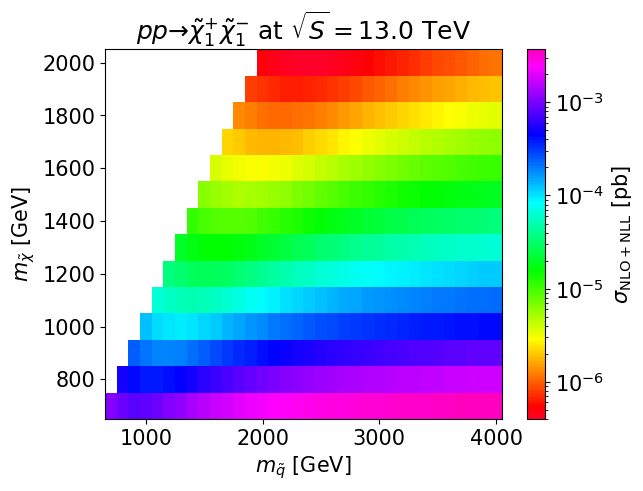

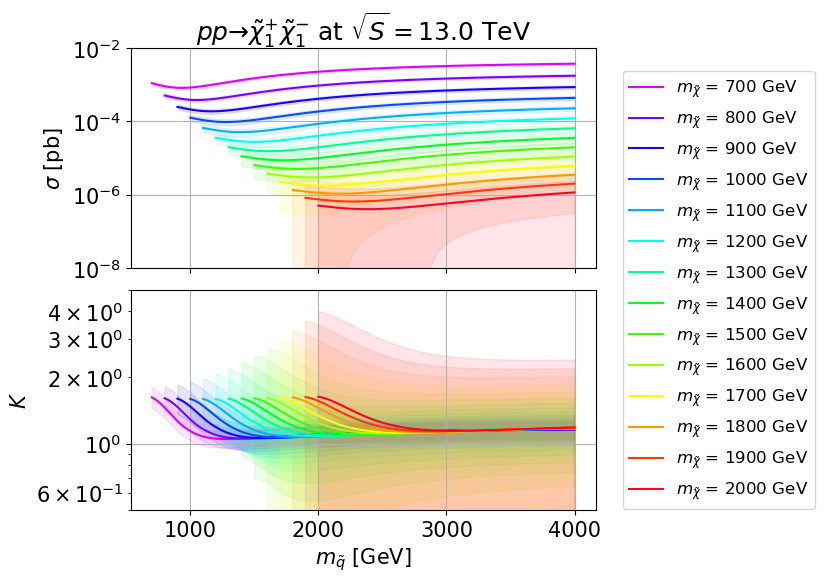

/home/apn/.local/lib/python3.9/site-packages/hepi/input.py:283: RuntimeWarning: Could not set new central scale to average of masses.
  warnings.warn("Could not set new central scale to average of masses.",


QUEUEING TASKS | Checking input:   0%|          | 0/18095 [00:00<?, ?it/s]

PROCESSING TASKS | Checking input:   0%|          | 0/18095 [00:00<?, ?it/s]

COLLECTING RESULTS | Checking input:   0%|          | 0/18095 [00:00<?, ?it/s]

QUEUEING TASKS | Preparing:   0%|          | 0/18095 [00:00<?, ?it/s]

PROCESSING TASKS | Preparing:   0%|          | 0/18095 [00:00<?, ?it/s]

COLLECTING RESULTS | Preparing:   0%|          | 0/18095 [00:00<?, ?it/s]

Skipped: 18095 Not skipped: 0


QUEUEING TASKS | Parsing:   0%|          | 0/18095 [00:00<?, ?it/s]

PROCESSING TASKS | Parsing:   0%|          | 0/18095 [00:00<?, ?it/s]

COLLECTING RESULTS | Parsing:   0%|          | 0/18095 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ LO:   0%|          | 0/385 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ LO:   0%|          | 0/385 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ LO:   0%|          | 0/385 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ NLO:   0%|          | 0/385 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ NLO:   0%|          | 0/385 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ NLO:   0%|          | 0/385 [00:00<?, ?it/s]

QUEUEING TASKS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/385 [00:00<?, ?it/s]

PROCESSING TASKS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/385 [00:00<?, ?it/s]

COLLECTING RESULTS | PDF uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/385 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ LO:   0%|          | 0/385 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ LO:   0%|          | 0/385 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ LO:   0%|          | 0/385 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ NLO:   0%|          | 0/385 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ NLO:   0%|          | 0/385 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ NLO:   0%|          | 0/385 [00:00<?, ?it/s]

QUEUEING TASKS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/385 [00:00<?, ?it/s]

PROCESSING TASKS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/385 [00:00<?, ?it/s]

COLLECTING RESULTS | Scale uncertainty @ aNNLO_PLUS_NNLL:   0%|          | 0/385 [00:00<?, ?it/s]

/home/apn/.local/lib/python3.9/site-packages/hepi/results.py:286: RuntimeWarning: too bad numerical precision vs scale @ num:aNNLO_PLUS_NNLL 0.06983402130103865% vs scale:0.2694303250401936% to 0.0%
  warnings.warn(


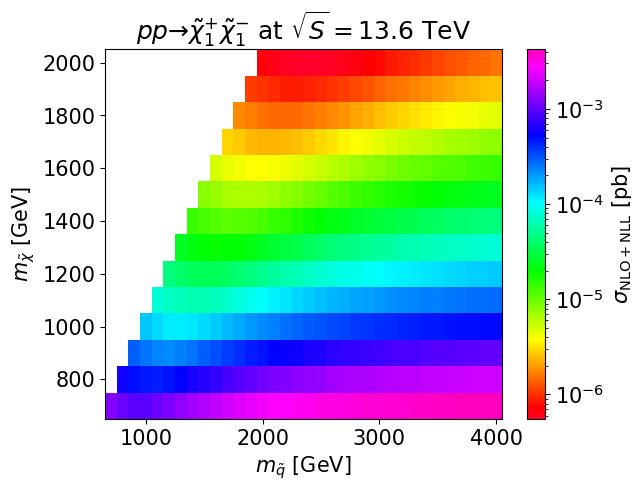

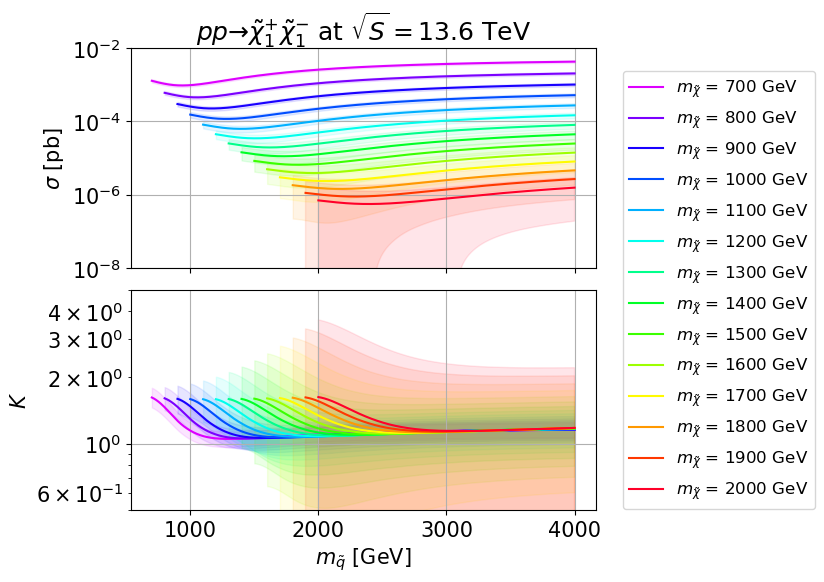

In [6]:
params = [
    "wino_sq.slha",
]
pss = [
    ( 1000023, +1000024),  # N1C1p
    ( 1000023, -1000024),  # N1C1m
    (+1000024, -1000024),  # C1pC1m
]
m_xs=range(700,2010,100)
for pa, pb in pss:
    for energy in [13000,13600]:
        name = "sqsq_" + str(energy) + "_wino_" + str(pa) + "_" + str(pb)
        hepi.set_output_dir(
            "output_" + name + "/"
        )
        rs.default_resummino_runner.set_output_dir(hepi.get_output_dir())
        for param in params:
            i = hepi.Input(
                hepi.Order.LO if test_lo else hepi.Order.aNNLO_PLUS_NNLL,
                    energy,
                    pa,
                    pb,
                    param,
                    "PDF4LHC21_40",
                    "PDF4LHC21_40",
                    1.0,
                    1.0,
                    id="0.0.0",
                    precision=0.001,
                    max_iters=50,
                )
            li = [i]
            li = hepi.masses_scan(
                   li,
                    [
                        1000022,
                        1000023,
                        1000024,
                     ],
                     m_xs,
                 )
            li = hepi.masses_scan(
                     li,
                    [
                       1000001,
                       1000002,
                       1000003,
                       1000004,
                       2000001,
                       2000002,
                       2000003,
                       2000004,
                   ],
                   range(700,4010,100), # decoupling else 1e5
               )
            li = hepi.remove_where(li,lambda d : d["mass_1000001_1000002_1000003_1000004_2000001_2000002_2000003_2000004"] < d["mass_1000022_1000023_1000024"])
            if test_lo:
                rs_dl = rs.run(li, skip=True, run=True, parse=True)
                hepi.mapplot(rs_dl,"mass_1000001_1000002_1000003_1000004_2000001_2000002_2000003_2000004","mass_1000022_1000023_1000024","LO",yaxis="$m_{\\tilde{\\chi}_1^0}$ [GeV]",xaxis="$m_{\\tilde{q}}$ [GeV]" , zaxis="$\\sigma_{\\mathrm{NLO+NLL}}$ [pb]")
                plt.show()
                for m_x in m_xs:
                    hepi.mass_plot(rs_dl[rs_dl["mass_1000022_1000023_1000024"]==m_x],"LO",1000002,data_fmt=".",lpos=6,bbox_to_anchor=(1.04,0.5),interpolate_label="$m_{\\tilde{\\chi}_1^0}$ = " + str(m_x) + "GeV",xaxis="$m_{\\tilde{q}}$ [GeV]",cont=True,plot_data=False,interpolate=True)
                plt.show()
            else:

                li = hepi.seven_point_scan(li)
                li = hepi.pdf_scan(li)
                    # li = hepi.change_where(li, {"precision": 0.0001, "max_iters": 200}, pdfset_nlo=0)
                if generate:
                    rs_dl = rs.run(li, skip=False, run=False, parse=False)
                else:
                    if analyse:
                        rs_dl = rs.run(li, skip=True, run=False, parse=True,ignore_error=True)
                        rs_dl = hepi.pdf_errors(li,rs_dl)
                        rs_dl = hepi.scale_errors(li,rs_dl)
                        rs_dl = hepi.combine_errors(rs_dl)
                        hepi.write_json(rs_dl[rs_dl["aNNLO_PLUS_NNLL_COMBINED"].notnull()],hepi.Order.aNNLO_PLUS_NNLL,["mass_1000001_1000002_1000003_1000004_2000001_2000002_2000003_2000004","mass_1000022_1000023_1000024"],name + "_NNLL.json",error_asym=True)
                        hepi.write_json(rs_dl[rs_dl["aNNLO_PLUS_NNLL_COMBINED"].notnull()],hepi.Order.NLO,["mass_1000001_1000002_1000003_1000004_2000001_2000002_2000003_2000004","mass_1000022_1000023_1000024"],name + "_NLO.json",error_asym=True)
                        hepi.write_json(rs_dl[rs_dl["aNNLO_PLUS_NNLL_COMBINED"].notnull()],hepi.Order.LO,["mass_1000001_1000002_1000003_1000004_2000001_2000002_2000003_2000004","mass_1000022_1000023_1000024"],name + "_LO.json",error_asym=True)

                        hepi.write_latex_table_transposed_header(rs_dl,"aNNLO_PLUS_NNLL",param+str(energy)+".tex","mass_1000001_1000002_1000003_1000004_2000001_2000002_2000003_2000004")
                        hepi.write_latex_table_transposed_header(rs_dl,"aNNLO_PLUS_NNLL",param+str(energy)+".tex","mass_1000022_1000023_1000024")
                        hepi.write_latex_table_transposed(rs_dl,"aNNLO_PLUS_NNLL",param+str(energy)+".tex",yscale=1000.)

                    if plot:
                        rs_dl = hepi.load_json(open(name + "_NNLL.json"),2)
                        #rs_dl_nlo = hepi.load_json(open(name + "_NLO.json"),2)
                        rs_dl["LO"]  = hepi.load_json(open(name + "_LO.json"),2)["LO_NOERR"]
                        mask = rs_dl["aNNLO_PLUS_NNLL_COMBINED"].notnull()
                        
                        hepi.title(li[0],axe=plt.gca(),cms_energy=True,pdf_info=False,scenario="")
                        hepi.mapplot(rs_dl[mask],"mass_1000001_1000002_1000003_1000004_2000001_2000002_2000003_2000004","mass_1000022_1000023_1000024","aNNLO_PLUS_NNLL_NOERR",yaxis="$m_{\\tilde{\\chi}}$ [GeV]",xaxis="$m_{\\tilde{q}}$ [GeV]" , zaxis="$\\sigma_{\\mathrm{NLO+NLL}}$ [pb]",cmap='gist_rainbow')
                        plt.savefig(name + "_map.pdf",bbox_inches ='tight',pad_inches=0)
                        plt.show()
                        
                        fig, axs = plt.subplots(2, 1, figsize=(6,6), sharex=True, gridspec_kw={'height_ratios': [2, 2]})         # Remove horizontal space between axes         
                        fig.subplots_adjust(hspace=0.1)
                        hepi.title(li[0],axe=axs[0],cms_energy=True,pdf_info=False,scenario="")
                                              
                        
                        axs[0].set_prop_cycle(color=[plt.get_cmap('gist_rainbow')(1.*i/len(m_xs)) for i in range(len(m_xs))[::-1]])
                        for m_x in m_xs:
                            hepi.combined_mass_plot(rs_dl[mask][rs_dl[mask]["mass_1000022_1000023_1000024"]==m_x],"aNNLO_PLUS_NNLL",1000002,axes=axs[0],alpha=0.1,tight=False,lpos=6,init=False,bbox_to_anchor=(1.04,-0.1),label="$m_{\\tilde{\\chi}}$ = " + str(m_x) + " GeV",cont=True,plot_data=False,interpolate=True)
                        axs[0].set_ylim(10**-8,10**-2)
                        axs[0].set_xlabel(None)
                        #plt.savefig(name + "_cut.pdf",bbox_inches ='tight',pad_inches=0)
                        #plt.show()
                        axs[1].set_prop_cycle(color=[plt.get_cmap('gist_rainbow')(1.*i/len(m_xs)) for i in range(len(m_xs))[::-1]])
                        for m_x in m_xs:
                            hepi.combined_mass_plot(rs_dl[mask][rs_dl[mask]["mass_1000022_1000023_1000024"]==m_x],"aNNLO_PLUS_NNLL",1000002,axes=axs[1],alpha=0.1,logy=True,K=True,tight=False,init=False,label="",cont=True,plot_data=False,interpolate=True)
                        axs[1].set_ylim(0.5,5 if pa == 1000024 else 10)
                        axs[1].set_xlabel('$m_{\\tilde{q}}$ [GeV]')
                        plt.savefig(name + "_slices.pdf",bbox_inches ='tight',pad_inches=0)
                        plt.show()
                        #hepi.write_latex_table_transposed_header(rs_dl,"aNNLO_PLUS_NNLL",param+str(energy)+".tex","mass_1000022")
                        #hepi.write_latex_table_transposed(rs_dl,"aNNLO_PLUS_NNLL",param+str(energy)+".tex",yscale=1000.)

 